In [1]:
## Suppress warnings for a cleaner output
import warnings
warnings.filterwarnings('ignore')
# Core libraries for data processing and mathematical operations
import matplotlib.pyplot as plt
import numpy as np
# Deep learning libraries
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D,BatchNormalization  # Layers for model customization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import os
import re
import tensorflow_datasets as tfds
from PIL import Image


# Essai 1 : Split + Modeling + Corrections des erreurs 


In [2]:
# Fonction pour extraire les coordonnées des boîtes englobantes à partir d'une chaîne de texte
def extract_coordinates(line):
    # Utiliser une expression régulière pour rechercher les coordonnées dans le format (x1,y1),(x2,y2)
    matches = re.findall(r'\((\d+),(\d+)\),\((\d+),(\d+)\)', line)
    if matches:
        # Récupérer les coordonnées x1, y1, x2, y2 de la première correspondance
        x1, y1, x2, y2 = map(int, matches[0])
        return (x1, y1, x2, y2)
    else:
        return None


In [3]:
# Créer un dataset à partir des images dans le dossier
image_folder = "C:/Users/user/Desktop/Projet deep learning/positive image set"

image_dataset = tf.data.Dataset.list_files(image_folder + "/*.jpg")

# Fonction pour charger et redimensionner les images
def load_and_resize_image(file_path,label):
    # Lire le contenu du fichier
    image = tf.io.read_file(file_path)
    # Décoder l'image au format RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # Redimensionner l'image à une taille spécifique
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0 
    return image,label

  

# Appliquer la fonction de chargement et redimensionnement aux images du dataset
# resized_images = image_dataset.map(load_and_resize_image)

# Afficher les dimensions des images redimensionnées
# for image in resized_images:  # Prendre les 10 premières images pour l'exemple
#     print("Shape de l'image :", image.shape)



In [4]:


# # Chemin vers le répertoire contenant les images
# image_folder = "positive image set/"
# # Chemin vers le répertoire contenant les fichiers de vérité terrain
# ground_truth_folder = "ground truth/"
# # Dictionnaire pour mapper les numéros de classe à leurs noms correspondants
# class_names = {
#     1: 'airplane',
#     2: 'ship',
#     3: 'storage tank',
#     4: 'baseball diamond',
#     5: 'tennis court',
#     6: 'basketball court',
#     7: 'ground track field',
#     8: 'harbor',
#     9: 'bridge',
#     10: 'vehicle'
# }


# # Parcourir chaque image et son fichier de vérité terrain
# for image_id in range(1, 651):
#     # Charger l'image
#     image_path = image_folder + f"{image_id:03d}.jpg"
#     image = cv2.imread(image_path)
    
#     # Charger les coordonnées des boîtes englobantes à partir du fichier de vérité terrain
#     ground_truth_path = ground_truth_folder + f"{image_id:03d}.txt"
#     with open(ground_truth_path, 'r') as file:
#         lines = file.readlines()
#         for line in lines:
#             coordinates = extract_coordinates(line)
#             parts = line.strip().split(',')
#             if coordinates:
#                 x1, y1, x2, y2 = coordinates
#                 label = int(parts[4])
#                 class_name = class_names[label]
#                 # Dessiner un rectangle sur l'image
#                 cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
#             # Afficher le label à côté de la boîte englobante
#                 cv2.putText(image, str(class_name), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

#     # Afficher l'image avec les boîtes englobantes
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title(f"Image {image_id}")
#     plt.axis('off')
#     plt.show()


In [5]:
def load_image_and_labels(image_folder, label_path, encoding='utf-8'):
    # Charger l'image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # Adapter la taille de l'image si nécessaire
    
    # Charger les labels à partir du fichier texte avec l'encodage spécifié
    with open(label_path, 'r', encoding=encoding) as file:
        labels = []
        for line in file.readlines():
            parts = line.strip().split(',')
            if len(parts) >= 2:
                label_str = parts[1]
                if label_str.isdigit():  # Vérifier si la chaîne est un nombre
                    labels.append(int(label_str))  # Convertir en entier si c'est le cas
    
    return image, labels

In [6]:
# image_folder = "positive image set/001.jpg"
# text_folder = "ground truth/001.txt"

# # Charger l'image et les labels avec l'encodage spécifié
# image, labels = load_image_and_labels(image_folder, text_folder, encoding='latin-1')

# # Afficher les labels correspondant à l'image
# print("Labels de l'image:", labels)

# Afficher tous les labels de tous les images

In [7]:
image_folder = "C:/Users/user/Desktop/Projet deep learning/positive image set"
label_dir = "C:/Users/user/Desktop/Projet deep learning/ground truth"
# Liste pour stocker les images et les labels
images = []
labels = []
# Parcourir les fichiers d'images dans le dossier
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        # Charger l'image à partir du fichier
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        images.append(image)
        
        # Extraire l'identifiant unique de l'image (par exemple, le nom de fichier sans extension)
        image_id = os.path.splitext(filename)[0]
        
        # Charger le fichier texte correspondant au label de cette image
        label_path = os.path.join(label_dir, f"{image_id}.txt")
        with open(label_path, 'r') as file:
            # Lire le label depuis le fichier texte et l'ajouter à la liste des labels
            label = file.read().strip()
            labels.append(label)

In [8]:
labels

['(563,478),(630,573),1',
 '(575,114),(635,162),1 \n( 72,305),(133,369),1 \n(210,317),(273,384),1 \n(306,374),(344,420),1 \n(447,531),(535,632),1 \n(546,605),(625,707),1 \n(632,680),(720,790),1',
 '(100,256),(170,319),1 \n(575,139),(668,240),1 \n(753,382),(843,484),1 \n(313,648),(415,764),1 \n(434,674),(527,787),1',
 '(227,106),(268,155),1 \n(318,126),(370,185),1 \n(445, 88),(516,168),1 \n(363,336),(438,420),1 \n(455,331),(529,415),1 \n( 68,316),(170,411),1 \n( 69,423),(180,525),1',
 '(401,596),(443,636),1 \n(606,138),(668,199),1',
 '(135,412),(182,472),1 \n(295,420),(347,470),1 \n(369,363),(415,419),1 \n(444,320),(534,432),1 \n(608,171),(704,255),1 \n(656, 62),(754,157),1 \n(317,555),(386,627),1 \n(479,695),(542,769),1',
 '(278,546),(361,630),1 \n(362,476),(434,545),1 \n(361,315),(457,411),1 \n(574,199),(666,293),1',
 '(208,361),(272,418),1 \n(234,429),(289,481),1 \n(322,473),(376,540),1 \n(313,631),(384,697),1',
 '(167,184),(232,241),1 \n(423,146),(456,174),1 \n(652, 73),(694,123),1 

# Afficher le label d'une image 001.jpg

In [9]:
# Nom de l'image et du fichier texte que vous voulez afficher
image_name = "252.jpg"
text_name = "252.txt"
labels1=[]
# Charger et afficher l'image
image_path = os.path.join(image_folder, image_name)
image = cv2.imread(image_path)


# Lire le contenu du fichier texte (label)
text_path = os.path.join(label_dir,text_name)
with open(text_path, 'r') as file:
    label = file.read().strip()
    labels1.append(label)

In [10]:
labels1

['(170,145),(548,362),7 \n(556,186),(600,242),5 \n(587,184),(633,240),5 \n(488,129),(529,184),5 \n(517,127),(556,182),5 \n(546,127),(584,178),5 \n(571,125),(611,175),5 \n(507, 74),(548,124),5 \n(536, 72),(577,120),5 \n(354, 23),(439, 84),4']

In [11]:
def extraire_chiffres_apres_coordonnees(chaine):
    # Expression régulière pour trouver les chiffres après les coordonnées
    pattern = r'\),(\d+)\s'

    # Utilisation de re.findall pour extraire les chiffres après les coordonnées
    chiffres_apres_coordonnees = re.findall(pattern, chaine)

    return chiffres_apres_coordonnees

In [12]:
for chaine in labels1:
    chiffres = extraire_chiffres_apres_coordonnees(chaine)
    print(chiffres)

['7', '5', '5', '5', '5', '5', '5', '5', '5']


In [13]:
#REMARQUE : Esemi les classes !!
# (1-airplane, 2-ship, 3-storage tank, 4-baseball diamond, 5-tennis court, 6-basketball court, 7-ground track field, 8-harbor, 9-bridge, 10-vehicle).

In [14]:
# pip install tensorflow-datasets --no-warn-script-location

# A) Phase de Test 

# 1- Modeling

In [15]:
image_dir = "C:/Users/user/Desktop/Projet deep learning/positive image set"

# Liste pour stocker les images et les labels correspondants
images = []
labels = []

# Parcourir les fichiers dans le répertoire d'images
for filename in os.listdir(image_dir):
    if filename.endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
        # Charger l'image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # Ajouter l'image à la liste des images
            images.append(image)
            
            # Extraire le label à partir du nom du fichier
            label = int(filename.split('.')[0])  # Suppose que le nom du fichier est l'ID de l'image
            labels.append(label)

# Vérifier la taille des données
print("Nombre d'images chargées:", len(images))
print("Nombre de labels:", len(labels))

Nombre d'images chargées: 650
Nombre de labels: 650


# 1-1Test D'un Bon Split entre Train , Test et Validation

In [16]:
#Essai 1
image_folder = "positive image set"


In [17]:
# Liste pour stocker les chemins des images
image_paths = []

# Parcourir les fichiers du répertoire
for file_name in os.listdir(image_folder):
    # Vérifier si le fichier est une image
    if file_name.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        # Construire le chemin absolu de l'image et l'ajouter à la liste
        image_path = os.path.join(image_folder, file_name)
        image_paths.append(image_path)

# Afficher les chemins des images
print(image_paths)

['positive image set\\001.jpg', 'positive image set\\002.jpg', 'positive image set\\003.jpg', 'positive image set\\004.jpg', 'positive image set\\005.jpg', 'positive image set\\006.jpg', 'positive image set\\007.jpg', 'positive image set\\008.jpg', 'positive image set\\009.jpg', 'positive image set\\010.jpg', 'positive image set\\011.jpg', 'positive image set\\012.jpg', 'positive image set\\013.jpg', 'positive image set\\014.jpg', 'positive image set\\015.jpg', 'positive image set\\016.jpg', 'positive image set\\017.jpg', 'positive image set\\018.jpg', 'positive image set\\019.jpg', 'positive image set\\020.jpg', 'positive image set\\021.jpg', 'positive image set\\022.jpg', 'positive image set\\023.jpg', 'positive image set\\024.jpg', 'positive image set\\025.jpg', 'positive image set\\026.jpg', 'positive image set\\027.jpg', 'positive image set\\028.jpg', 'positive image set\\029.jpg', 'positive image set\\030.jpg', 'positive image set\\031.jpg', 'positive image set\\032.jpg', 'positi

In [18]:
# # Diviser les données en ensembles d'entraînement et de test
# train_images, test_images, train_labels, test_labels = train_test_split(
#     image_paths, labels, test_size=0.3, random_state=42
# )


In [19]:
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# # Fonction pour charger et prétraiter les images
# def load_and_preprocess_image(image_path, label):
#     # Charger l'image
#     image = load_img(image_path, target_size=(224, 224))  # Redimensionner si nécessaire
#     # Convertir l'image en tableau numpy
#     image_array = img_to_array(image)
#     # Prétraitement supplémentaire si nécessaire (normalisation, augmentation de données, etc.)
#     return image_array, label

# # Charger et prétraiter les images d'entraînement
# train_data = []
# for image_path, label in zip(train_images, train_labels):
#     image_array, label = load_and_preprocess_image(image_path, label)
#     train_data.append((image_array, label))

# # Charger et prétraiter les images de test
# test_data = []
# for image_path, label in zip(test_images, test_labels):
#     image_array, label = load_and_preprocess_image(image_path, label)
#     test_data.append((image_array, label))

# # Convertir les listes en tableaux numpy
# train_images, train_labels = zip(*train_data)
# test_images, test_labels = zip(*test_data)

# # Convertir en tableaux numpy
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

# # Vérifier les dimensions des ensembles de données
# print("Train images shape:", train_images.shape)
# print("Train labels shape:", train_labels.shape)
# print("Test images shape:", test_images.shape)
# print("Test labels shape:", test_labels.shape)

## Premier Essaie

In [20]:
# #REMARQUE , EL RAK 9AAED TESTAAMAL FIL IMAGE_DATASET ROD BELEK !!!T7ESSHA HKEYA MAHACH LOGIQUE

# #Remarque : aandek 8altza dima yepredicti el valeur 2 eli hiya chip aaandek 8alta houni lezmek tsala7ha
# #jarreb man8ir chuufle !!! wel validation split
# # Chemin vers le répertoire contenant les images
#  #
#  # lezemech naamal chufffle 5ater les images ikounou mixtes Or que les documents text y93do mnadhmine statiquement
#  # hatta ki taamal spit taa el trainig  70% hatta zeda taamal split taa el documents texts mnadhmine man8ir chuffle !!
# image_dir = "C:/Users/user/Desktop/Projet deep learning"

# # Créer un dataset à partir des images dans le répertoire
# image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_dir,
#     labels="inferred",
#     label_mode="int",
#     batch_size=32,  # Nombre d'images à charger en même temps
#     image_size=(224, 224),  # Taille des images
#     shuffle=False,  # Mélanger les images
#     seed=123,  # Seed pour la reproductibilité
#     validation_split=0.4,  # Fraction des données à utiliser pour la validation
#     subset="training"
#     # Indiquer qu'il s'agit de l'ensemble d'entraînement
# )

# # Afficher les classes détectées
# print(image_dataset.class_names)
# # Chargement du sous-ensemble de validation


In [21]:
# parts = line.strip().split(',')
# label = int(parts[4])

# Le Split , train_dataset et val_dataset avec labellage extreme

In [22]:
images_str = "(575,114),(635,162),1 \n(72,305),(133,369),1 \n(210,317),(273,384),1 \n(306,374),(344,420),1 \n(447,531),(535,632),1 \n(546,605),(625,707),1 \n(632,680),(720,790),1"

def extract_labels_numeriques(images_str):
    # Diviser la chaîne en lignes
    lines = images_str.split('\n')

    # Initialiser une liste pour stocker les labels extraits
    labels = []

    # Parcourir chaque ligne pour extraire le chiffre à gauche
    for line in lines:
        parts = line.split(',')  # Séparer les parties de la ligne
        if parts:
            label = parts[-1]  # Récupérer le dernier élément de chaque partie
            label = label.strip()  # Supprimer les espaces et sauts de ligne
            labels.append(label)

    return labels

# Exemple d'utilisation de la fonction avec la chaîne d'images


In [23]:
def process_labels(labels):
    processed_labels = []
    for label in labels:
        processed_label = extract_labels_numeriques(label)
        processed_labels.append(processed_label)
    return processed_labels

In [24]:
# def label_generator():
#     for image_path, label in zip(train_image_paths, train_labels):
#         yield image_path, label

In [25]:
# Exemple de listes de tuples
#el mochkla les tuples lezemhom ikounou fard dimensions moch kima ('4'), moch kima ('4', '4', '4', '4', '4', '4')!!
#sinon bich tjik erreur :
# ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.
# processed_labels_tuplesaaa = [('4'), ('4', '4', '4', '4', '4', '4'), ('4', '4', '4', '4', '4'),
#                            ('4', '4', '5', '5', '5', '5'), ('4', '4', '4'), ('4', '4', '6'),
#                            ('4', '4', '4', '4', '4', '4'), ('4', '4', '4', '4', '4', '4'),
#                            ('4', '4', '4', '4', '6'), ('4'), ('4', '4', '4', '4', '4'),
#                            ('4', '4', '4', '5', '5', '5', '5')]

#
# Trouver la taille maximale des tuples
def fill_tuples_with_zeros(tuples_list):
    # Trouver la taille maximale des tuples
    max_length = max(len(item) for item in tuples_list)
    
    # Remplacer les tuples plus courts par des 'zeros' pour garder les mêmes dimensions
    filled_tuples = [item + ('0',) * (max_length - len(item)) for item in tuples_list]
    
    filled_tuples_int = [[int(char) for char in item] for item in filled_tuples]
    
    # Convertir les tuples en un tableau NumPy
    filled_tuples_np = np.array(filled_tuples_int)
    
    filled_tuples_tensor = tf.constant(filled_tuples_np, dtype=tf.int32)
    
    return filled_tuples_tensor

# Exemple d'utilisation de la fonction
processed_labels_tuplesaaa = [('4',), ('4', '4', '4', '4', '4', '4'), ('4', '4', '4', '4', '4'),
                           ('4', '4', '5', '5', '5', '5'), ('4', '4', '4'), ('4', '4', '6'),
                           ('4', '4', '4', '4', '4', '4'), ('4', '4', '4', '4', '4', '4'),
                           ('4', '4', '4', '4', '6'), ('4',), ('4', '4', '4', '4', '4'),
                           ('4', '4', '4', '5', '5', '5', '5')]

processed_labels_npeee = fill_tuples_with_zeros(processed_labels_tuplesaaa)
print(processed_labels_npeee)

# Convertir le tableau NumPy en un tensor TensorFlow de type tf.string
test_labels_tensor = tf.constant(processed_labels_npeee, dtype=tf.int32)

tf.Tensor(
[[4 0 0 0 0 0 0]
 [4 4 4 4 4 4 0]
 [4 4 4 4 4 0 0]
 [4 4 5 5 5 5 0]
 [4 4 4 0 0 0 0]
 [4 4 6 0 0 0 0]
 [4 4 4 4 4 4 0]
 [4 4 4 4 4 4 0]
 [4 4 4 4 6 0 0]
 [4 0 0 0 0 0 0]
 [4 4 4 4 4 0 0]
 [4 4 4 5 5 5 5]], shape=(12, 7), dtype=int32)


In [26]:
def label_generator():
    for label in processed_labels:
        yield label

In [27]:
def process_labels_without_zeros_np(labels_np):
    processed_labels = []
    for label_array in labels_np:
        # Supprimer les zéros de l'array de labels
        processed_label = [str(label) for label in label_array if label != 0]
        # Convertir la liste de labels en une seule chaîne de caractères
        label_string = ''.join(processed_label)
        processed_labels.append(label_string)
    return processed_labels

# Appliquer la fonction pour éliminer les zéros et convertir en chaînes de caractères
# processed_labels_strings_np = process_labels_without_zeros_np(data_np)

# Vérifier les résultats
# print(processed_labels_strings_np[:10])  # Afficher les 10 premiers labels pour vérification

In [28]:
# Créer un tenseur exemple
tenseur_exemple = tf.constant([1, 2, 3, 4, 5])

# Liste d'indices
indices = [2, 4, 1]

# Utiliser tf.gather pour accéder aux éléments avec les indices spécifiés
elements_selectionnes = tf.gather(tenseur_exemple, indices)

# Afficher les éléments sélectionnés
print(elements_selectionnes.numpy())

[3 5 2]


In [29]:

# Chemin vers le dossier contenant les images
image_dir = "C:/Users/user/Desktop/Projet deep learning/positive image set"
# Chemin vers le dossier contenant les labels (ground truth)
label_dir = "C:/Users/user/Desktop/Projet deep learning/ground truth"

# Liste pour stocker les chemins des images
image_paths = []
# Liste pour stocker les labels
labels = []

# Parcourir les fichiers dans le dossier des images
for filename in os.listdir(image_dir):
    # Vérifier que le fichier est une image
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Ajouter le chemin de l'image à la liste
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename)
        #image_resized=preprocess_image(image_path)
#         image_resized=load_and_resize_image(image_path)
        image_paths.append(image_path)

        # Construire le chemin du fichier de label correspondant
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        # Lire le label depuis le fichier texte et l'ajouter à la liste des labels
        with open(label_path, 'r') as file:
            label = file.read().strip()
#            label_int=extract_class(label)
#             label_int = extract_labels(label)
            labels.append(label)

# Extraire les labels et les traiter pour ne garder que le chiffre à la fin
processed_labels = process_labels(labels) 
processed_labels_tuples = [tuple(label) for label in processed_labels]

dataTuples=fill_tuples_with_zeros(processed_labels_tuples)
# Convertir les tuples remplis avec des zéros en un tableau NumPy

data_np = np.array(dataTuples)

processed_labels_strings_np = process_labels_without_zeros_np(data_np)

# Créer un dictionnaire pour mapper les labels aux entiers
label_to_int = {label: i for i, label in enumerate(set(processed_labels_strings_np))}

# Convertir les labels en entiers en utilisant le dictionnaire
labels_integers = [label_to_int[label] for label in processed_labels_strings_np]



labels_tensor = tf.constant(processed_labels_strings_np, dtype=tf.string)

# Diviser les données en ensembles d'entraînement et de validation
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_integers, test_size=0.2, random_state=42)            
#REAMRQUE : FIL SPLITE 5OUDH EL data_np mouch labels_tensor !!!

# Créer les datasets à partir des ensembles d'entraînement et de validation avec prétraitement
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
# Créer les datasets à partir des ensembles d'entraînement et de validation avec prétraitement
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))

# train_dataset = tf.data.Dataset.from_generator(
#     label_generator, output_signature=(tf.string, tf.int32))

# train_dataset = tf.data.Dataset.from_generator(
#     label_generator, output_signature=(tf.string, tf.int32))
# val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
# train_dataset = train_dataset.map(load_and_resize_image)

# train_dataset.map(lambda image, label: (tf.expand_dims(image, 0), label))


# val_dataset = val_dataset.map(load_and_resize_image)

# load_and_resize_image(file_path)
# resized_images = image_dataset.map(load_and_resize_image)


In [30]:
#BIL CODE HEDHA EL MODEL YA5DEM AMMAA ACCURACY 5AYAB !!!
#REMARQUE , 7AWALNA EL LES LABELS ILA DES ENTIERS wel les entiers hedhouma homwa el identifant taa les labes originaux
#Exemple:
# {'2': 134,
#  '1': 135,
#  '1111111111111111111111111111111': 136,
#  '1010': 137,
#  '75': 138,
#  '10101010101010101010': 139,}
#Mithal awal taswira feha tayara barka (yaani '1' wahad barka normlzoulou ib 135)

# # Vos labels originaux sous forme de chaînes de caractères
# labels_strings = ['1', '1111111', '11111', '1111111', '11', '11111111', '1111', '1111', '111111', '111111', '111111111', '11', '1111111111111', '1111111111', '1111111', '11111111', '11111111113333333333', '11111', '111111', '1111111111', '11111111111111333333333333', '11111111111111111', '11111', '11111111111111111111111111', '1111111111', '111111', '111111111111111111111', '111111111', '11111111111']

# # Créer un dictionnaire pour mapper les labels aux entiers
# label_to_int = {label: i for i, label in enumerate(set(processed_labels_strings_np))}

# # Convertir les labels en entiers en utilisant le dictionnaire
# labels_integers = [label_to_int[label] for label in processed_labels_strings_np]

# # Afficher les labels convertis en entiers
# print(labels_integers)


In [31]:
# data_tensor = tf.ragged.constant(processed_labels)



In [32]:
# # Remarque: hehdi mchet bidoun hatta machakal amma ki taamal split tjik erreur

# # Convertir les tuples remplis avec des zéros en un tableau NumPy
# data_np = np.array(dataTuples)
# # Convertir le tableau NumPy en un tensor TensorFlow de type tf.int32
# data_tensor = tf.constant(data_np, dtype=tf.int32)

# # Utiliser data_tensor dans votre Dataset
# dataset = tf.data.Dataset.from_tensor_slices(labels_tensor)
# # train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels_tensor))  rahi temchi lebes aliha hatta ki tafficheha fil les images

In [33]:
# # Convertir la liste en un tableau NumPy
# # test_labels_np = np.array(processed_labels_tuples)

# processed_labels_np = np.array(processed_labels_tuples)

# # Convertir le tableau NumPy en un tensor TensorFlow de type tf.int32
# test_labels_tensor = tf.constant(processed_labels_tuples, dtype=tf.int32)
# # Utiliser val_labels_tensor dans votre Dataset
# test_dataset = tf.data.Dataset.from_tensor_slices((image_paths, val_labels_tensor))

In [34]:
# Exemple de listes de tuples
processed_labels_tupleszzzzz = [('1',4), (3, 4), (5, 6)]

# Convertir des tuples en un tableau NumPy
processed_labels_nppp = np.array(processed_labels_tupleszzzzz)

# Convertir le tableau NumPy en un tensor TensorFlow de type tf.int32
test_labels_tensorrr = tf.constant(processed_labels_nppp, dtype=tf.int32)

# Afficher le tensor TensorFlow résultant
print(test_labels_tensorrr)

tf.Tensor(
[[1 4]
 [3 4]
 [5 6]], shape=(3, 2), dtype=int32)


In [35]:
# processed_labels_tuples

# affichage de quelques images 

In [36]:
def load_and_display_image(image_path, label):
    # Charger l'image à partir du chemin
    image = plt.imread(image_path)

    # Afficher l'image avec le label
    plt.imshow(image)
    plt.title(f"Label: {label}")
    plt.axis('off')  # Masquer les axes
    plt.show()



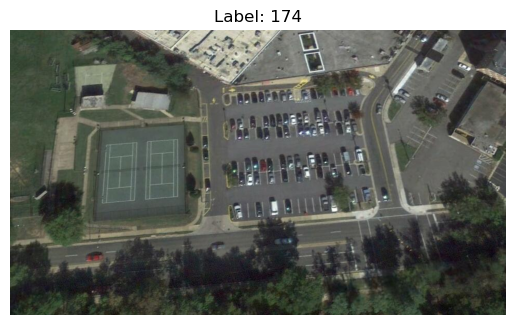

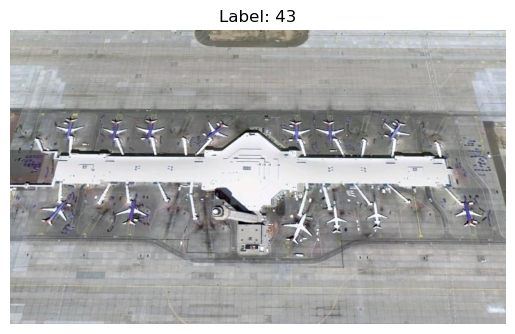

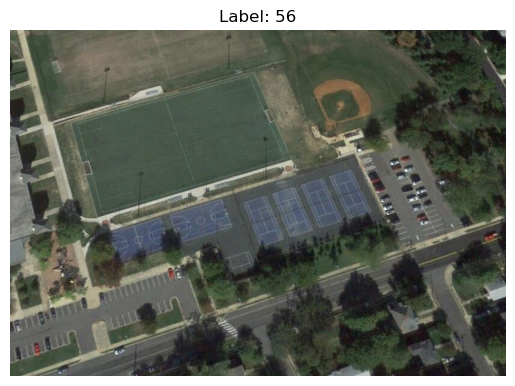

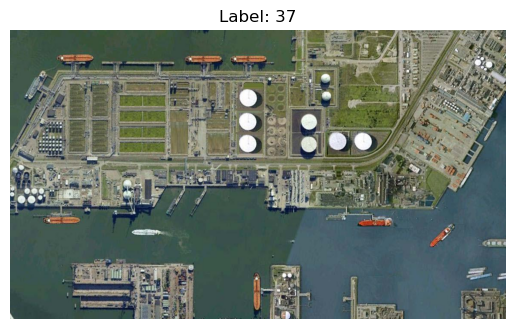

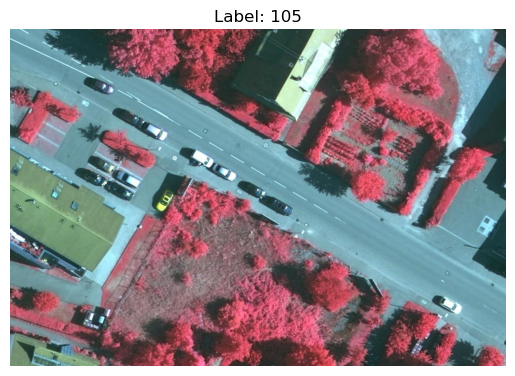

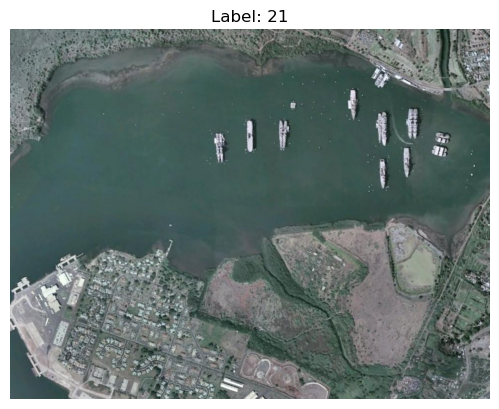

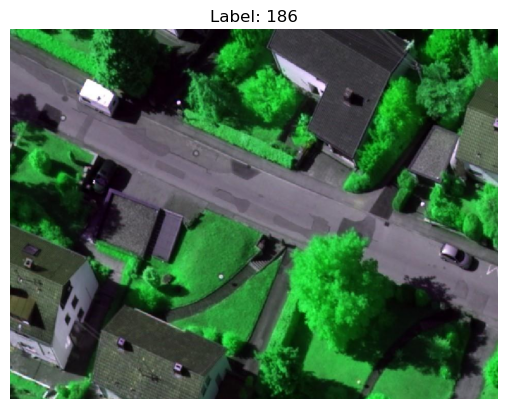

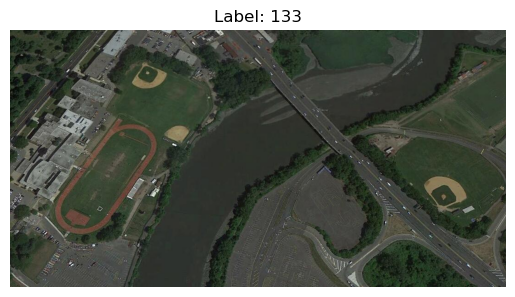

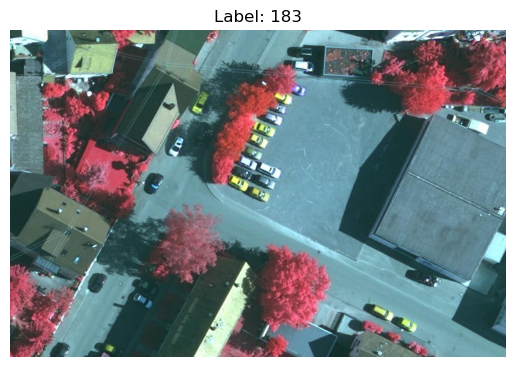

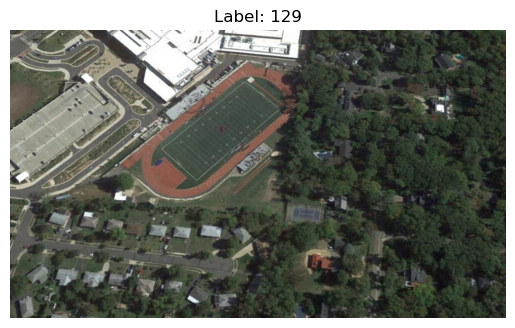

In [37]:
#Yamchiew bil behi !!
# Parcourir le train_dataset pour charger et afficher les images
for image_path, label in train_dataset.take(10):  # Prendre les 10 premièraes images pour l'exemple
    # Convertir le chemin de l'image en chaîne de caractères
    image_path_str = image_path.numpy().decode('utf-8')
    # Charger et afficher l'image
    load_and_display_image(image_path_str, label)

# Remarque : baad maraj3na les valeurs lo5rina '0' lezem tw naawdo na7ihouhom ou nrodo liste kamla taa label tweli string hawka kol image aandha label string (eli howa liste de classes)

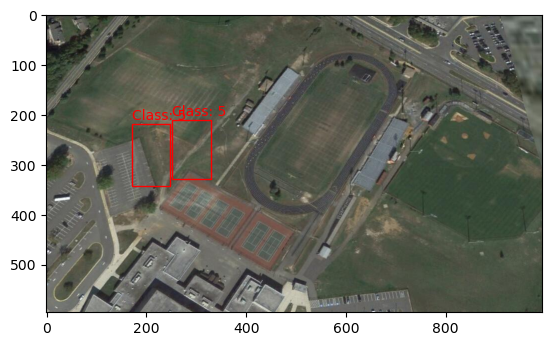

In [38]:
# Fonction pour afficher une image avec ses étiquettes
import matplotlib.patches as patches
def display_image_with_labels(image_path, labels_info):
    # Charger l'image à partir du chemin
    image = plt.imread(image_path)
    
    # Créer une figure et des axes pour l'image
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    # Parcourir toutes les étiquettes dans labels_info
    for class_label, coordinates in labels_info:
        # Extraire les coordonnées
        x1, y1, x2, y2 = coordinates
        
        # Calculer la largeur et la hauteur du rectangle
        width = x2 - x1
        height = y2 - y1
        
        # Créer un rectangle avec les coordonnées et la classe
        rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
        
        # Ajouter le rectangle à l'axe
        ax.add_patch(rect)
        
        # Ajouter le texte de la classe à l'axe
        ax.text(x1, y1 - 10, f'Class: {class_label}', color='r', fontsize=10)
    
    # Afficher l'image avec les rectangles et les étiquettes
    plt.show()

# Chemin de l'image que vous souhaitez afficher
image_path = "C:/Users/user/Desktop/Projet deep learning/positive image set/202.jpg"

# Extraire les informations sur les étiquettes de l'image
# Notez que vous devez adapter ceci en fonction de la façon dont vous avez stocké les informations sur les étiquettes
image_labels_info = [(5, (172, 219, 248, 343)), (5, (251, 211, 330, 329))]

# Afficher l'image avec les étiquettes
display_image_with_labels(image_path, image_labels_info)

In [39]:
# Chaîne d'exemple contenant les coordonnées et les chiffres
chaine_exemple = "Label:b'(172,219),(248,343),5 \n(251,211),(330,329),5'"

# Expression régulière pour extraire les coordonnées et le chiffre
pattern = r'\((\d+),(\d+)\),\((\d+),(\d+)\),(\d+)'

# Utilisation de re.findall pour extraire les informations
resultats = re.findall(pattern, chaine_exemple)

# Affichage des résultats
for res in resultats:
    x1, y1, x2, y2, chiffre = res
    print(f"Coordonnées : ({x1}, {y1}), ({x2}, {y2}) - Chiffre : {chiffre}")

Coordonnées : (172, 219), (248, 343) - Chiffre : 5
Coordonnées : (251, 211), (330, 329) - Chiffre : 5


In [40]:
for res in resultats:
    print(res)

('172', '219', '248', '343', '5')
('251', '211', '330', '329', '5')


In [41]:
labels

['(563,478),(630,573),1',
 '(575,114),(635,162),1 \n( 72,305),(133,369),1 \n(210,317),(273,384),1 \n(306,374),(344,420),1 \n(447,531),(535,632),1 \n(546,605),(625,707),1 \n(632,680),(720,790),1',
 '(100,256),(170,319),1 \n(575,139),(668,240),1 \n(753,382),(843,484),1 \n(313,648),(415,764),1 \n(434,674),(527,787),1',
 '(227,106),(268,155),1 \n(318,126),(370,185),1 \n(445, 88),(516,168),1 \n(363,336),(438,420),1 \n(455,331),(529,415),1 \n( 68,316),(170,411),1 \n( 69,423),(180,525),1',
 '(401,596),(443,636),1 \n(606,138),(668,199),1',
 '(135,412),(182,472),1 \n(295,420),(347,470),1 \n(369,363),(415,419),1 \n(444,320),(534,432),1 \n(608,171),(704,255),1 \n(656, 62),(754,157),1 \n(317,555),(386,627),1 \n(479,695),(542,769),1',
 '(278,546),(361,630),1 \n(362,476),(434,545),1 \n(361,315),(457,411),1 \n(574,199),(666,293),1',
 '(208,361),(272,418),1 \n(234,429),(289,481),1 \n(322,473),(376,540),1 \n(313,631),(384,697),1',
 '(167,184),(232,241),1 \n(423,146),(456,174),1 \n(652, 73),(694,123),1 

In [42]:
# # Parcourir le train_dataset pour charger et afficher les images
# for image_path, label in train_dataset.take(10):  # Prendre les 10 premièraes images pour l'exemple
#     # Convertir le chemin de l'image en chaîne de caractères
#     image_path_str = image_path.numpy().decode('utf-8')
#     # Charger et afficher l'image
#     display_image_with_labels(image_path_str, label)

# Baaad ma taffiichi el tsawar wa9tha testaamal el Image preprocess

In [43]:
# Ahayaa !!!!!!!
# train_dataset = train_dataset.map(load_and_resize_image) 

# REMARQUE

In [44]:
#REMARQUE : ALECH LES VLAUERS REELS TAA LES LABLES DIMA YA 1 Ya 2  alech lo5rina mahomch mawjoudine
#REMARQUE , EL RAK 9AAED TESTAAMAL FIL IMAGE_DATASET ROD BELEK !!!T7ESSHA HKEYA MAHACH LOGIQUE

for images, labels in train_dataset:
    print(labels)

tf.Tensor(174, shape=(), dtype=int32)
tf.Tensor(43, shape=(), dtype=int32)
tf.Tensor(56, shape=(), dtype=int32)
tf.Tensor(37, shape=(), dtype=int32)
tf.Tensor(105, shape=(), dtype=int32)
tf.Tensor(21, shape=(), dtype=int32)
tf.Tensor(186, shape=(), dtype=int32)
tf.Tensor(133, shape=(), dtype=int32)
tf.Tensor(183, shape=(), dtype=int32)
tf.Tensor(129, shape=(), dtype=int32)
tf.Tensor(111, shape=(), dtype=int32)
tf.Tensor(101, shape=(), dtype=int32)
tf.Tensor(218, shape=(), dtype=int32)
tf.Tensor(102, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(74, shape=(), dtype=int32)
tf.Tensor(186, shape=(), dtype=int32)
tf.Tensor(117, shape=(), dtype=int32)
tf.Tensor(108, shape=(), dtype=int32)
tf.Tensor(64, shape=(), dtype=int32)
tf.Tensor(205, shape=(), dtype=int32)
tf.Tensor(172, shape=(), dtype=int32)
tf.Tensor(198, shape=(), dtype=int32)
tf.Tensor(40, shape=(), dtype=int32)
tf.Tensor(51, shape=(), dtype=int32)
tf.Tensor(100, shape=(), dtype=int32)
tf.Tensor(52, shape=()

In [45]:
# #HEDHA BEHI OU LAKTHERIYA YETNABA2 BIL S7I7 !!!BIL TARI9A HEDHI
# #REMARQUE : dima zeda el classe el theltha eli hiya ground truth dima e7sebha mawjouda bich el model yaamal prediction:!!
# # Chemin vers le répertoire contenant les images positives
# positive_image_dir = "C:/Users/user/Desktop/Projet deep learning/positive image set"
# # Chemin vers le répertoire contenant les images négatives
# # negative_image_dir = "C:/Users/user/Desktop/Projet deep learning/negative image set"

# # Créer un dataset à partir des images dans le répertoire positif
# positive_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_dir,
#     labels=labels_integers,
#     label_mode="int",
#     batch_size=32,
#     image_size=(224, 224),
#     shuffle=False,
#     seed=11.0,
#     validation_split=0.2,
#     subset="training"  # Training set basé sur le répertoire des images positives
# )
# negative_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_dir,
#     labels="inferred",
#     label_mode="int",
#     batch_size=32,
#     image_size=(224, 224),
#     shuffle=False,
#     seed=123,
#     validation_split=0.5,
#     subset="validation"  # Test set basé sur le répertoire des images négatives
# )


# # Afficher les classes détectées
# print(positive_image_dataset.class_names)  # Classes du training set (positives)
# print(negative_image_dataset.class_names)  # Classes du test set (négatives)

## Deuxieme Essai

In [46]:
# #hedha 5ayab chweya 
# # Créer un dataset à partir des images dans le répertoire positif
# positive_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_dir,
#     labels="inferred",
#     label_mode="int",
#     batch_size=32,
#     image_size=(224, 224),
#     shuffle=False,
#     seed=11.0,
#     validation_split=0.3,
#     subset="training"  # Training set basé sur le répertoire des images positives
# )

## Troisieme Essai

In [47]:
# #REMARUQ HEDHI MCHET BILGDE BILGDE !!!!!!!!!ou mahach overfitting
 
# Créer un dataset à partir des images dans le répertoire
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    labels=labels_integers,  # Inférer automatiquement les labels à partir des noms de dossiers
    batch_size=32,       # Nombre d'images à charger en même temps
    image_size=(224, 224),  # Taille des images
    shuffle=False,        # Mélanger les images pour un apprentissage aléatoire
    seed=123,            # Seed pour la reproductibilité
    validation_split=0.2,  # Fraction des données à utiliser pour la validation
    subset="training"    # Indiquer qu'il s'agit de l'ensemble d'entraînement
)

# Afficher les classes détectées
print(image_dataset.class_names)

# # Charger le sous-ensemble de validation
# val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     image_dir,
#     labels=labels_integers,
#     label_mode="int",
#     batch_size=32,
#     image_size=(224, 224),
#     shuffle=False,
#     seed=123,
#     validation_split=0.2,
#     subset="validation"  # Indiquer qu'il s'agit de l'ensemble de validation
# )

# # Afficher les classes détectées pour le sous-ensemble de validation
# print(val_dataset.class_names)

Found 650 files belonging to 219 classes.
Using 520 files for training.
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 20

In [48]:
labels_integers

[53,
 60,
 69,
 60,
 95,
 118,
 51,
 51,
 157,
 157,
 24,
 95,
 43,
 16,
 60,
 118,
 158,
 69,
 157,
 16,
 130,
 58,
 69,
 192,
 16,
 157,
 93,
 24,
 79,
 43,
 24,
 163,
 60,
 118,
 181,
 157,
 109,
 189,
 24,
 16,
 60,
 60,
 71,
 104,
 51,
 157,
 169,
 118,
 118,
 189,
 153,
 24,
 165,
 69,
 95,
 24,
 69,
 163,
 118,
 95,
 51,
 95,
 69,
 95,
 69,
 51,
 152,
 60,
 69,
 60,
 79,
 124,
 53,
 124,
 51,
 60,
 157,
 51,
 95,
 124,
 110,
 86,
 46,
 44,
 106,
 122,
 46,
 139,
 172,
 86,
 172,
 211,
 177,
 122,
 139,
 141,
 211,
 211,
 206,
 172,
 177,
 164,
 139,
 211,
 205,
 172,
 86,
 46,
 172,
 172,
 86,
 201,
 46,
 177,
 172,
 86,
 46,
 172,
 106,
 172,
 120,
 172,
 100,
 172,
 86,
 172,
 205,
 172,
 86,
 172,
 172,
 38,
 77,
 184,
 184,
 184,
 184,
 184,
 55,
 1,
 173,
 198,
 173,
 173,
 5,
 80,
 68,
 50,
 50,
 184,
 184,
 184,
 184,
 184,
 173,
 198,
 173,
 55,
 184,
 173,
 173,
 184,
 184,
 184,
 217,
 217,
 61,
 61,
 61,
 61,
 61,
 217,
 216,
 61,
 61,
 61,
 217,
 61,
 61,
 102,
 61,


In [49]:
def preprocess_image(image_path):
    # Lire l'image depuis le fichier
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)  # Décode l'image en RGB

    # Obtenir la forme de l'izmage
    image_shape = tf.shape(image)

    # Redimensionne l'image
    image = tf.image.resize(image, (224, 224))

    # Normalise les valeurs des pixels entre 0 et 1
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [50]:
image_path = "C:/Users/user/Desktop/Projet deep learning/positive image set/001.jpg"
preprocess_image(image_path)

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3007703 , 0.34641105, 0.18954833],
        [0.3001266 , 0.35795227, 0.20488039],
        [0.30829832, 0.3710434 , 0.22594537],
        ...,
        [0.35826138, 0.41316333, 0.27590844],
        [0.35753596, 0.41243792, 0.28302616],
        [0.37419137, 0.42517176, 0.3075247 ]],

       [[0.2979126 , 0.34355333, 0.19169761],
        [0.3029762 , 0.3572129 , 0.21537115],
        [0.2955035 , 0.3582486 , 0.21707213],
        ...,
        [0.34641117, 0.40131313, 0.26405823],
        [0.3527273 , 0.40762925, 0.2782175 ],
        [0.3520825 , 0.40306288, 0.28541583]],

       [[0.30208242, 0.34630507, 0.20654668],
        [0.30229342, 0.3565301 , 0.21894257],
        [0.29131183, 0.35013536, 0.2207236 ],
        ...,
        [0.34788164, 0.38709733, 0.25376397],
        [0.33164948, 0.3669436 , 0.24537498],
        [0.52003807, 0.5553322 , 0.44160673]],

       ...,

       [[0.44429383, 0.4991958 , 0.4482154 ],
        [0.43

In [51]:
# Parcourir le train_dataset pour afficher les shapes des images
for image, label in train_dataset:
    # Afficher la forme de l'image
    preprocess_image(image)
    print("Shape de l'image :", image.shape)


Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l

Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l'image : ()
Shape de l

In [52]:

# Définir la taille cible des images redimensionnées
target_size = (224, 224)  # Par exemple, 224x224 pixels

# Fonction pour charger et redimensionner une image
def load_and_resize_image(image_path):
    # Charger l'image depuis le chemin spécifié
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Décodez l'image en RGB

    # Redimensionner l'image à la taille cible
    image = tf.image.resize(image, target_size)

    return image

# Appliquer la fonction de chargement et de redimensionnement aux images et labels de l'ensemble d'entraînement
# train_dataset_resized = train_dataset.map(load_and_resize_image)
# val_dataset_resized = val_dataset.map(load_and_resize_image)

# Essai 2 15/04/2024 (Un essai réussie avec succées)

In [53]:
###ESSAIS 4 15/04/2024 #######################


#EL FIKRA HIYA , N7AWLO EL LES OBJETS KIMA LES AVIONS LES BATEAUX ILA DES IMAGES M3A EL LABELS TA3HOM wa7dhom !!!!

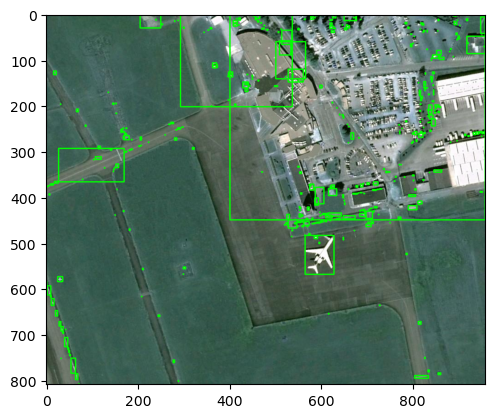

In [54]:
# Charger l'image

image_path = 'C:/Users/user/Desktop/Projet deep learning/positive image set/001.jpg'
image = cv2.imread(image_path)

# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Appliquer un seuillage pour binariser l'image
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Trouver les contours dans l'image binarisée
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dessiner les boîtes englobantes des contours trouvés
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Afficher l'image avec les boîtes englobantes
plt.imshow(image)


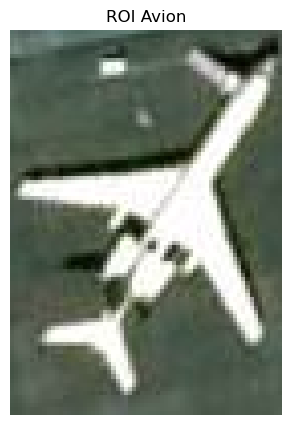

In [55]:
# Fonction pour extraire la région d'intérêt (ROI) de chaque boîte englobante
def extract_roi(image, coord1, coord2):
    x1, y1 = coord1
    x2, y2 = coord2
    roi = image[y1:y2, x1:x2]  # Extraction de la région d'intérêt (ROI)
    return roi

# Charger l'image d'origine
image_path = 'C:/Users/user/Desktop/Projet deep learning/positive image set/001.jpg'
image = cv2.imread(image_path)


# Coordonnées de la région d'intérêt (xmin, ymin, xmax, ymax) pour l'avion
coord1 = (563, 478)
coord2 = (630, 573)

# Configuration de la figure Matplotlib pour afficher la ROI de l'avion
fig, ax = plt.subplots(1, 1, figsize=(5, 5))  # Créer la figure et l'axe


# Extraire la ROI de l'avion et l'afficher dans la figure
roi = extract_roi(image,coord1, coord2)
ax.imshow(roi)  # Afficher la ROI dans l'axe correspondant
ax.axis('off')  # Désactiver les axes pour une meilleure présentation
ax.set_title('ROI Avion')  # Ajouter un titre à la ROI de l'avion

plt.show()  # Afficher la figure avec la ROI de l'avion

In [56]:
### DANS LE CAS GENERAL !!! ###########

In [132]:
# Chemin vers le dossier contenant les images et les fichiers de ground truth
images_folder = 'C:/Users/user/Desktop/Projet deep learning/positive image set'
ground_truth_folder = 'C:/Users/user/Desktop/Projet deep learning/ground truth'

# Dossier de sortie pour les objets extraits
output_folder = 'C:/Users/user/Desktop/Projet deep learning/objets_extraits'
os.makedirs(output_folder, exist_ok=True)

# Parcourir les fichiers de ground truth et extraire les objets
for gt_file in os.listdir(ground_truth_folder):
    # Lire chaque fichier de ground truth
    with open(os.path.join(ground_truth_folder, gt_file), 'r') as file:
        lines = file.readlines()
    
    # Charger l'image correspondante
    image_name = os.path.splitext(gt_file)[0] + '.jpg'
    image_path = os.path.join(images_folder, image_name)
    image = cv2.imread(image_path)
    
    # Parcourir les lignes du fichier de ground truth
    for line in lines:
        data = line.strip().split(',')
        if len(data) == 5:
            # Supprimer les caractères non numériques et convertir en entiers
            coordinates = [int(coord.strip('()')) for coord in data[:4]]
            label = int(data[4])  # Convertir le label en entier
            
            # Extraire l'objet de l'image
            x1, y1, x2, y2 = coordinates
            # Extraire l'objet de l'image
            object_roi = image[y1:y2, x1:x2]
            # Enregistrer l'objet extrait avec le label correspondant
            output_filename = f'{label}_{image_name}'
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, object_roi)

In [133]:
# Chemin vers le dossier contenant les objets extraits
extracted_objects_folder = 'C:/Users/user/Desktop/Projet deep learning/objets_extraits'

# Listes pour stocker les chemins des images et leurs labels
image_paths_Fin = []
labelsFin = []

# Parcourir les fichiers dans le dossier des objets extraits
for filename in os.listdir(extracted_objects_folder):
    if filename.endswith('.jpg'):
        # Extraire le label à partir du nom du fichier
        label = int(filename.split('_')[0])
        labelsFin.append(label)
        
        # Chemin complet de l'image
        image_path = os.path.join(extracted_objects_folder, filename)
        image_paths_Fin.append(image_path)

# Convertir les listes en tableaux NumPy pour une manipulation plus facile
image_paths_Fin = np.array(image_paths_Fin)
labelsFin = np.array(labelsFin)

# # Diviser les données en ensembles d'entraînement et de test (80% pour l'entraînement, 20% pour le test)
# x_train, x_test, y_train, y_test = train_test_split(image_paths_Fin, labelsFin, test_size=0.3, random_state=42)


# Diviser les données en ensembles d'entraînement, de validation et de test (70% pour l'entraînement, 20% pour la validation, 10% pour le test)
x_train, x_val_test, y_train, y_val_test = train_test_split(image_paths_Fin, labelsFin, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=1/3, random_state=42)  # Diviser le reste en val et test

# Afficher le nombre d'échantillons dans chaque ensemble
print(f'Nombre d\'échantillons total : {len(image_paths_Fin)}')
print(f'Nombre d\'échantillons dans l\'ensemble d\'entraînement : {len(x_train)}')
print(f'Nombre d\'échantillons dans l\'ensemble de validation : {len(x_val)}')
print(f'Nombre d\'échantillons dans l\'ensemble de test : {len(x_test)}')


# # Afficher le nombre d'échantillons dans chaque ensemble
# print(f'Nombre d\'échantillons total : {len(image_paths_Fin)}')
# print(f'Nombre d\'échantillons dans l\'ensemble d\'entraînement : {len(x_train)}')
# print(f'Nombre d\'échantillons dans l\'ensemble de test : {len(x_test)}')

Nombre d'échantillons total : 888
Nombre d'échantillons dans l'ensemble d'entraînement : 621
Nombre d'échantillons dans l'ensemble de validation : 178
Nombre d'échantillons dans l'ensemble de test : 89


In [59]:
x_train

array(['C:/Users/user/Desktop/Projet deep learning/objets_extraits\\5_338.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\4_112.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\1_521.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\5_148.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\4_480.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\4_252.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\8_271.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\1_005.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\9_176.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\2_288.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\5_250.jpg',
       'C:/Users/user/Desktop/Projet deep learning/objets_extraits\\7_648.jpg',
       'C:/Users/user/Desktop/Projet dee

In [131]:
y_train

array([ 4, 10,  8, 10,  7,  7,  4,  6,  2,  3,  0,  0,  5,  1,  2,  1,  6,
        0, 10,  2, 10,  9,  0,  6,  2,  9,  7,  0,  5,  5,  7,  6,  9,  1,
        0,  0,  6,  0,  6,  7,  5,  2,  2,  0,  5,  9, 10, 10,  0,  6, 10,
        9,  5,  9, 10,  3,  3, 10, 10, 10,  9,  1,  5, 10,  6,  2,  0, 10,
        3,  3,  2,  6,  8,  8,  1,  3,  4,  4,  8,  7,  0, 10,  1,  6,  9,
        9,  7,  6, 10,  1,  3,  2,  7,  4,  8,  0,  4,  4, 10, 10])

In [134]:
def preprocess_data(images):
    processed_images = []
    for image in images:
        # Redimensionner l'image à la taille spécifique (par exemple, 224x224)
        resized_image = cv2.resize(image, (224, 224))
        # Normaliser les valeurs de pixel dans la plage [0, 1]
        normalized_image = resized_image.astype(np.float32) / 255.0
        processed_images.append(normalized_image)
    return np.array(processed_images)

In [135]:
resized_images = [load_and_resize_image(image) for image in x_train]
resized_images_test = [load_and_resize_image(image) for image in x_test]
resized_images_val = [load_and_resize_image(image) for image in x_val_test]

In [136]:
# Convertir les listes en Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((resized_images, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((resized_images_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((resized_images_val, y_val_test))

In [64]:
def load_and_preprocess_image(file_path):
    # Charger l'image en niveaux de gris
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # Redimensionner l'image à la taille spécifique (par exemple, 224x224)
    resized_image = cv2.resize(image, (224, 224))
    # Convertir les valeurs de pixel en type float et normaliser
    preprocessed_image = resized_image.astype(np.float32) / 255.0
    return preprocessed_image

# Charger et prétraiter toutes les images d'entraînement et de test
x_train_preprocessed = np.array([load_and_preprocess_image(file_path) for file_path in x_train])
x_test_preprocessed = np.array([load_and_preprocess_image(file_path) for file_path in x_test])



# Utiliser .reshape(-1, 1) pour convertir en une matrice avec une seule colonne
# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [65]:
########################################################################

In [66]:
# Define image dimensions and batch size
IMG_SIZE = 224
channels = 3
BATCH_SIZE = 32

def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5)  # A max_delta of 0.5 means that the brightness will be randomly adjusted by a value between -0.5 and 0.5
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)
    return image, label

def format_images(image, label):
    image = tf.cast(image, tf.float32) #convert the pixel values of the image to floating-point format.
    image = (image/255) - 1  #NORMALIZATION
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))

    return image, label

In [137]:
train_ds = train_dataset.map(format_images)
validation_batches = val_dataset.map(format_images).batch(BATCH_SIZE)
test_batches = test_dataset.map(format_images).batch(BATCH_SIZE)

In [68]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


modelCNN=keras.Sequential()

modelCNN.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.2))

modelCNN.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.25))

modelCNN.add(Flatten())

modelCNN.add(Dense(128, activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(64, activation='relu'))
modelCNN.add(BatchNormalization())
modelCNN.add(Dense(11, activation='softmax'))

# Compiler le modèle avec l'optimiseur Adam
optimizer = Adam(learning_rate=0.001)

modelCNN.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

modelCNN.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 32)     

In [69]:
SHUFFLE_BUFFER_SIZE = 3000
AUTOTUNE = tf.data.AUTOTUNE 

train_batches = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [70]:
epochs=10

historyCNN = modelCNN.fit(
  train_batches,
  validation_data=validation_batches,
  epochs=epochs
)

Epoch 1/10


20/20 [==============================] - 14s 545ms/step - loss: 2.2378 - accuracy: 0.3430 - val_loss: 2.3667 - val_accuracy: 0.2022
Epoch 2/10
20/20 [==============================] - 10s 509ms/step - loss: 1.3760 - accuracy: 0.5990 - val_loss: 2.3707 - val_accuracy: 0.1910
Epoch 3/10
20/20 [==============================] - 11s 569ms/step - loss: 1.0774 - accuracy: 0.6731 - val_loss: 2.3874 - val_accuracy: 0.2285
Epoch 4/10
20/20 [==============================] - 10s 516ms/step - loss: 0.8755 - accuracy: 0.7440 - val_loss: 2.4371 - val_accuracy: 0.2434
Epoch 5/10
20/20 [==============================] - 10s 498ms/step - loss: 0.6979 - accuracy: 0.8100 - val_loss: 2.4560 - val_accuracy: 0.2247
Epoch 6/10
20/20 [==============================] - 10s 492ms/step - loss: 0.5704 - accuracy: 0.8535 - val_loss: 2.5200 - val_accuracy: 0.3071
Epoch 7/10
20/20 [==============================] - 10s 497ms/step - loss: 0.4430 - accuracy: 0.8905 - val_loss: 2.4719 - val_accuracy: 0.31

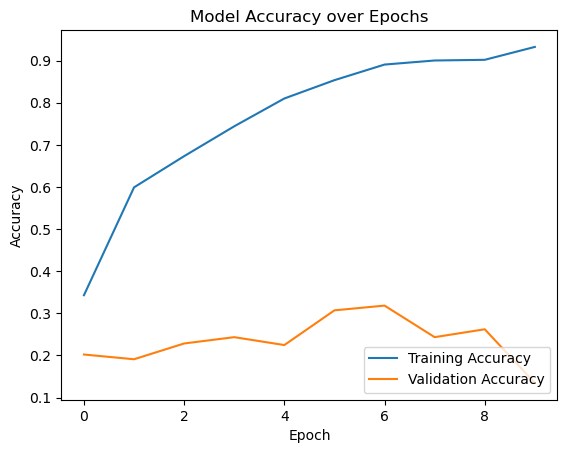

In [71]:
# Visualize model training and validation accuracy
plt.plot(historyCNN.history['accuracy'], label='Training Accuracy')
plt.plot(historyCNN.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.regularizers import l2



Epoch 1/5
4/4 [==============================] - 2s 214ms/step - loss: 3.3314 - accuracy: 0.0900 - val_loss: 2.2560 - val_accuracy: 0.0500
Epoch 2/5
4/4 [==============================] - 1s 127ms/step - loss: 2.7623 - accuracy: 0.1400 - val_loss: 2.2373 - val_accuracy: 0.2500
Epoch 3/5
4/4 [==============================] - 0s 101ms/step - loss: 2.9008 - accuracy: 0.1000 - val_loss: 2.3977 - val_accuracy: 0.0500
Epoch 4/5
4/4 [==============================] - 0s 110ms/step - loss: 2.6002 - accuracy: 0.1900 - val_loss: 2.4046 - val_accuracy: 0.0500
Epoch 5/5
1/1 [==============================] - 0s 168ms/step
Epoch 1/5
4/4 [==============================] - 2s 202ms/step - loss: 3.3683 - accuracy: 0.0800 - val_loss: 26.3598 - val_accuracy: 0.0000e+00
Epoch 2/5
4/4 [==============================] - 1s 120ms/step - loss: 0.9294 - accuracy: 0.7500 - val_loss: 15.1847 - val_accuracy: 0.0000e+00
Epoch 3/5
4/4 [==============================] - 0s 120ms/step - loss: 0.5533 - accuracy: 0.9

[]

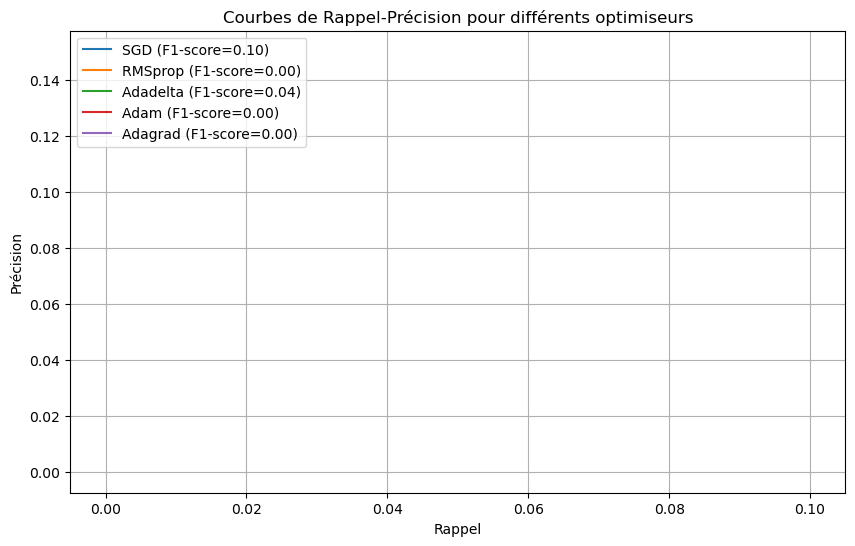

In [73]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Adagrad
from sklearn.metrics import precision_recall_fscore_support

# Définir les optimiseurs à tester
optimizers = {
    'SGD': SGD(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'Adadelta': Adadelta(learning_rate=0.001),
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.001),
}

# Fonction pour construire le modèle avec un optimiseur spécifique
def build_model(optimizer):
    model = keras.Sequential([
        Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, channels), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(32, 3, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(11, activation='softmax')
    ])
    # Compiler le modèle avec l'optimiseur spécifique
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Construire, entraîner et évaluer chaque modèle avec un optimiseur différent
models = {}
results = {}

# Données factices pour illustrer
IMG_SIZE = 128
channels = 3
x_train, y_train = np.random.randn(100, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 100)
x_val, y_val = np.random.randn(20, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 20)


for optimizer_name, optimizer in optimizers.items():
    model = build_model(optimizer)
    model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_val, y_val))
    models[optimizer_name] = model
    y_pred = model.predict(x_val)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
    results[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

# Dessiner les courbes de rappel-précision pour chaque modèle
plt.figure(figsize=(10, 6))
for optimizer_name, result in results.items():
    plt.plot(result['recall'], result['precision'], label=f'{optimizer_name} (F1-score={result["f1_score"]:.2f})')

plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbes de Rappel-Précision pour différents optimiseurs')
plt.legend()
plt.grid(True)
plt.plot()


In [74]:
 results

{'SGD': {'precision': 0.15, 'recall': 0.1, 'f1_score': 0.10476190476190476},
 'RMSprop': {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0},
 'Adadelta': {'precision': 0.02142857142857143,
  'recall': 0.1,
  'f1_score': 0.03529411764705882},
 'Adam': {'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0},
 'Adagrad': {'precision': 0.0025,
  'recall': 0.05,
  'f1_score': 0.0047619047619047615}}

In [75]:
# Extraire les valeurs pour l'optimiseur "SGD"
sgd_values = results['SGD']

# Transformer les valeurs en liste
sgd_list = [sgd_values['precision'], sgd_values['recall'], sgd_values['f1_score']]

print(sgd_list)  # Affiche la liste des valeurs associées à l'optimiseur "SGD"



[0.15, 0.1, 0.10476190476190476]


In [76]:
# Extraire toutes les valeurs de précision
precision_values = [results[key]['precision'] for key in results]

print(precision_values)  # Affiche la liste des valeurs de précision pour chaque optimiseur




[0.15, 0.0, 0.02142857142857143, 0.0, 0.0025]


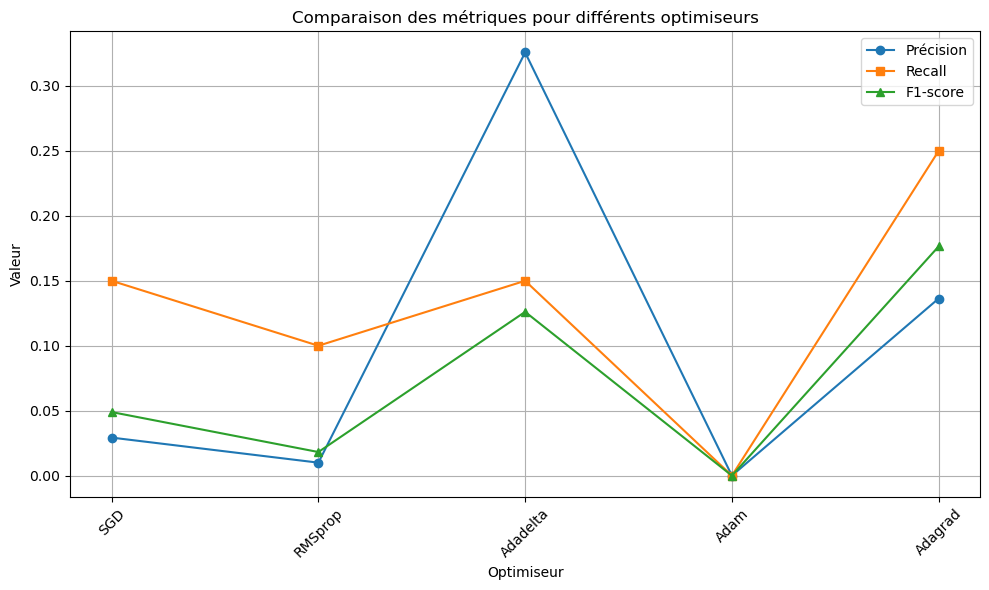

In [77]:
from matplotlib import pyplot as plt

# Récupérer les données du dictionnaire
optimizers = ['SGD', 'RMSprop', 'Adadelta', 'Adam', 'Adagrad']
precision_values = [0.029292929292929294, 0.01, 0.32575757575757575, 0.0, 0.13636363636363635]
recall_values = [0.15, 0.1, 0.15, 0.0, 0.25]
f1_scores = [0.048951048951048945, 0.01818181818181818, 0.1260989010989011, 0.0, 0.1764705882352941]

# Plotter les valeurs de précision, rappel et f1-score pour chaque optimiseur
plt.figure(figsize=(10, 6))

# Précision
plt.plot(optimizers, precision_values, marker='o', label='Précision')

# Rappel
plt.plot(optimizers, recall_values, marker='s', label='Recall')

# F1-score
plt.plot(optimizers, f1_scores, marker='^', label='F1-score')

# Ajouter des étiquettes et une légende
plt.xlabel('Optimiseur')
plt.ylabel('Valeur')
plt.title('Comparaison des métriques pour différents optimiseurs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()


In [78]:
# pip install PyQt6

In [79]:
# import matplotlib
# matplotlib.use("QtAgg")

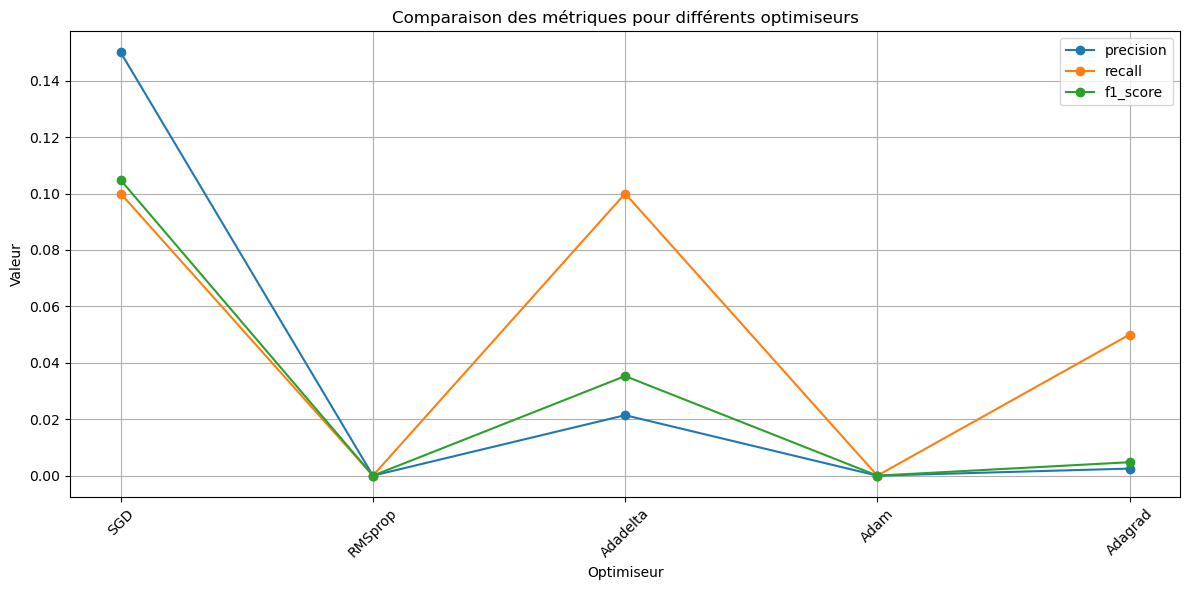

In [80]:
#Remarqque : hedhzh dans le cas general amma howa iheb yaamal model 3al airplane baad yaaamal model ala el ship , yaani 
#kol entité wahadha yaaamal aleha model ou isawar el precision wel recall !!!
# Métriques à tracer
metrics = ['precision', 'recall', 'f1_score']

# Création des plots dynamiques
plt.figure(figsize=(12, 6))

for metric in metrics:
    values = [ results[optimizer][metric] for optimizer in results]
    plt.plot(list(results.keys()), values, marker='o', label=metric)

# Ajout des étiquettes et de la légende
plt.xlabel('Optimiseur')
plt.ylabel('Valeur')
plt.title('Comparaison des métriques pour différents optimiseurs')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

In [81]:
#Train Airplane
train_ds_filtered_airplane = train_dataset.filter(lambda image, label: label == 1)

train_ds_filtered_airplane = train_ds_filtered_airplane.map(format_images)

train_batches_filtered_airplane = train_ds_filtered_airplane.batch(BATCH_SIZE)
#Validation Airplane
validation_ds_filtered_airplane = val_dataset.filter(lambda image, label: label == 1)

validation_ds_filtered_airplane = validation_ds_filtered_airplane.map(format_images)

validation_ds_filtered_airplane = validation_ds_filtered_airplane.batch(BATCH_SIZE)

#Test Airplane
test_ds_filtered_airplane = test_dataset.filter(lambda image, label: label == 1)

test_ds_filtered_airplane = test_ds_filtered_airplane.map(format_images)

test_ds_filtered_airplane = test_ds_filtered_airplane.batch(BATCH_SIZE)




# validation_batches = val_dataset.map(format_images).batch(BATCH_SIZE)


# test_batches = test_dataset.map(format_images).batch(BATCH_SIZE)


In [82]:
#Train Ship
train_ds_filtered_ship= train_dataset.filter(lambda image, label: label == 2)

train_ds_filtered_ship = train_ds_filtered_ship.map(format_images)

train_batches_filtered_ship = train_ds_filtered_ship.batch(BATCH_SIZE)
#Validation Ship
validation_ds_filtered_ship = val_dataset.filter(lambda image, label: label == 2)

validation_ds_filtered_ship = validation_ds_filtered_ship.map(format_images)

validation_ds_filtered_ship = validation_ds_filtered_ship.batch(BATCH_SIZE)

#Test Ship
test_ds_filtered_ship = test_dataset.filter(lambda image, label: label ==2)

test_ds_filtered_ship = test_ds_filtered_ship.map(format_images)

test_ds_filtered_ship = test_ds_filtered_ship.batch(BATCH_SIZE)




# validation_batches = val_dataset.map(format_images).batch(BATCH_SIZE)


# test_batches = test_dataset.map(format_images).batch(BATCH_SIZE)


In [83]:
#Train storage tank
train_ds_filtered_storage= train_dataset.filter(lambda image, label: label == 3)

train_ds_filtered_storage = train_ds_filtered_storage.map(format_images)

train_batches_filtered_storage = train_ds_filtered_storage.batch(BATCH_SIZE)
#Validation storage tank
validation_ds_filtered_storage = val_dataset.filter(lambda image, label: label == 3)

validation_ds_filtered_storage = validation_ds_filtered_storage.map(format_images)

validation_ds_filtered_storage = validation_ds_filtered_storage.batch(BATCH_SIZE)

#Test storage tank
test_ds_filtered_storage = test_dataset.filter(lambda image, label: label == 3)

test_ds_filtered_storage = test_ds_filtered_storage.map(format_images)

test_ds_filtered_storage = test_ds_filtered_storage.batch(BATCH_SIZE)
#Train baseball
train_ds_filtered_baseball= train_dataset.filter(lambda image, label: label == 4)

train_ds_filtered_baseball = train_ds_filtered_baseball.map(format_images)

train_batches_filtered_baseball = train_ds_filtered_baseball.batch(BATCH_SIZE)
#Validation baseball
validation_ds_filtered_baseball = val_dataset.filter(lambda image, label: label == 4)

validation_ds_filtered_baseball = validation_ds_filtered_baseball.map(format_images)

validation_ds_filtered_baseball = validation_ds_filtered_baseball.batch(BATCH_SIZE)

#Test baseball
test_ds_filtered_baseball = test_dataset.filter(lambda image, label: label == 4)

test_ds_filtered_baseball = test_ds_filtered_baseball.map(format_images)

test_ds_filtered_baseball = test_ds_filtered_baseball.batch(BATCH_SIZE)
#Train tennis
train_ds_filtered_tennis= train_dataset.filter(lambda image, label: label == 5)

train_ds_filtered_tennis = train_ds_filtered_tennis.map(format_images)

train_batches_filtered_tennis = train_ds_filtered_tennis.batch(BATCH_SIZE)

#Validation baseball
validation_ds_filtered_tennis= val_dataset.filter(lambda image, label: label == 5)

validation_ds_filtered_tennis = validation_ds_filtered_tennis.map(format_images)

validation_ds_filtered_tennis = validation_ds_filtered_tennis.batch(BATCH_SIZE)

#Test baseball
test_ds_filtered_tennis = test_dataset.filter(lambda image, label: label == 5)

test_ds_filtered_tennis = test_ds_filtered_tennis.map(format_images)

test_ds_filtered_tennis = test_ds_filtered_tennis.batch(BATCH_SIZE)
#Train basketball
train_ds_filtered_basketball= train_dataset.filter(lambda image, label: label == 6)

train_ds_filtered_basketball = train_ds_filtered_basketball.map(format_images)

train_batches_filtered_basketball = train_ds_filtered_basketball.batch(BATCH_SIZE)
#Validation basketball
validation_ds_filtered_basketball= val_dataset.filter(lambda image, label: label == 6)

validation_ds_filtered_basketball = validation_ds_filtered_basketball.map(format_images)

validation_ds_filtered_basketball = validation_ds_filtered_basketball.batch(BATCH_SIZE)

#Test basketball
test_ds_filtered_basketball = test_dataset.filter(lambda image, label: label == 6)

test_ds_filtered_basketball = test_ds_filtered_basketball.map(format_images)

test_ds_filtered_basketball = test_ds_filtered_basketball.batch(BATCH_SIZE)


#Train ground
train_ds_filtered_ground= train_dataset.filter(lambda image, label: label == 7)

train_ds_filtered_ground = train_ds_filtered_ground.map(format_images)

train_batches_filtered_ground = train_ds_filtered_ground.batch(BATCH_SIZE)
#Validation ground
validation_ds_filtered_ground= val_dataset.filter(lambda image, label: label == 7)

validation_ds_filtered_ground = validation_ds_filtered_ground.map(format_images)

validation_ds_filtered_ground = validation_ds_filtered_ground.batch(BATCH_SIZE)

#Test ground
test_ds_filtered_ground = test_dataset.filter(lambda image, label: label == 7)

test_ds_filtered_ground = test_ds_filtered_ground.map(format_images)

test_ds_filtered_ground = test_ds_filtered_ground.batch(BATCH_SIZE)
#Train harbor
train_ds_filtered_harbor= train_dataset.filter(lambda image, label: label == 8)
train_ds_filtered_harbor = train_ds_filtered_harbor.map(format_images)

train_batches_filtered_harbor = train_ds_filtered_harbor.batch(BATCH_SIZE)
#Validation harbor
validation_ds_filtered_harbor= val_dataset.filter(lambda image, label: label == 8)

validation_ds_filtered_harbor = validation_ds_filtered_harbor.map(format_images)

validation_ds_filtered_harbor = validation_ds_filtered_harbor.batch(BATCH_SIZE)

#Test harbor
test_ds_filtered_harbor = test_dataset.filter(lambda image, label: label == 8)

test_ds_filtered_harbor = test_ds_filtered_harbor.map(format_images)

test_ds_filtered_harbor = test_ds_filtered_harbor.batch(BATCH_SIZE)
#Train bridge
train_ds_filtered_bridge= train_dataset.filter(lambda image, label: label == 9)
train_ds_filtered_bridge = train_ds_filtered_bridge.map(format_images)

train_batches_filtered_bridge = train_ds_filtered_bridge.batch(BATCH_SIZE)
#Validation bridge
validation_ds_filtered_bridge= val_dataset.filter(lambda image, label: label == 9)

validation_ds_filtered_bridge = validation_ds_filtered_bridge.map(format_images)

validation_ds_filtered_bridge = validation_ds_filtered_bridge.batch(BATCH_SIZE)

#Test bridge
test_ds_filtered_bridge= test_dataset.filter(lambda image, label: label == 9)

test_ds_filtered_bridge = test_ds_filtered_bridge.map(format_images)

test_ds_filtered_bridge = test_ds_filtered_bridge.batch(BATCH_SIZE)

#Train vehicle
train_ds_filtered_vehicle= train_dataset.filter(lambda image, label: label == 10)
train_ds_filtered_vehicle = train_ds_filtered_vehicle.map(format_images)

train_batches_filtered_vehicle = train_ds_filtered_vehicle.batch(BATCH_SIZE)
#Validation vehicle
validation_ds_filtered_vehicle= val_dataset.filter(lambda image, label: label == 10)

validation_ds_filtered_vehicle = validation_ds_filtered_vehicle.map(format_images)

validation_ds_filtered_vehicle = validation_ds_filtered_vehicle.batch(BATCH_SIZE)

#Test vehicle
test_ds_filtered_vehicle= test_dataset.filter(lambda image, label: label == 10)

test_ds_filtered_vehicle = test_ds_filtered_vehicle.map(format_images)

test_ds_filtered_vehicle = test_ds_filtered_vehicle.batch(BATCH_SIZE)

In [84]:
#Model Airplane Label =1

modelAirplane=keras.Sequential()

modelAirplane.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
modelAirplane.add(BatchNormalization())
modelAirplane.add(MaxPooling2D(pool_size=(2, 2)))
modelAirplane.add(Dropout(0.2))

modelAirplane.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
modelAirplane.add(BatchNormalization())
modelAirplane.add(MaxPooling2D(pool_size=(2, 2)))
modelAirplane.add(Dropout(0.25))

modelAirplane.add(Flatten())

modelAirplane.add(Dense(128, activation='relu'))
modelAirplane.add(BatchNormalization())
modelAirplane.add(Dense(64, activation='relu'))
modelAirplane.add(BatchNormalization())
modelAirplane.add(Dense(11, activation='softmax'))

# Compiler le modèle avec l'optimiseur Adam
optimizer = Adam(learning_rate=0.001)

modelAirplane.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

modelAirplane.summary()


SHUFFLE_BUFFER_SIZE = 3000
AUTOTUNE = tf.data.AUTOTUNE 

train_batches_plane = train_ds_filtered_airplane.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

epochs=10

historyAirplane = modelAirplane.fit(
  train_batches_plane,
  validation_data=validation_ds_filtered_airplane,
  epochs=epochs
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 batch_normalization_24 (Ba  (None, 126, 126, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_25 (Ba  (None, 61, 61, 32)       

In [85]:
# #Model Airplane Label =1

# modelShip=keras.Sequential()

# modelShip.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelShip.add(BatchNormalization())
# modelShip.add(MaxPooling2D(pool_size=(2, 2)))
# modelShip.add(Dropout(0.2))

# modelShip.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelShip.add(BatchNormalization())
# modelShip.add(MaxPooling2D(pool_size=(2, 2)))
# modelShip.add(Dropout(0.25))

# modelShip.add(Flatten())

# modelShip.add(Dense(128, activation='relu'))
# modelShip.add(BatchNormalization())
# modelShip.add(Dense(64, activation='relu'))
# modelShip.add(BatchNormalization())
# modelShip.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelShip.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelShip.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_ship = train_ds_filtered_ship.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# epochs=10

# historyShip = modelShip.fit(
#   train_batches_filtered_ship,
#   validation_data=validation_ds_filtered_ship,
#   epochs=epochs
# )

In [86]:
# ###################################################3- Storage Tanks###################################################
# modelStorage=keras.Sequential()

# modelStorage.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelStorage.add(BatchNormalization())
# modelStorage.add(MaxPooling2D(pool_size=(2, 2)))
# modelStorage.add(Dropout(0.2))

# modelStorage.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelStorage.add(BatchNormalization())
# modelStorage.add(MaxPooling2D(pool_size=(2, 2)))
# modelStorage.add(Dropout(0.25))

# modelStorage.add(Flatten())

# modelStorage.add(Dense(128, activation='relu'))
# modelStorage.add(BatchNormalization())
# modelStorage.add(Dense(64, activation='relu'))
# modelStorage.add(BatchNormalization())
# modelStorage.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelStorage.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelStorage.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Storage = train_ds_filtered_storage.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

# epochs=10

# historyStorage = modelStorage.fit(
#   train_batches_filtered_storage,
#   validation_data=validation_ds_filtered_storage,
#   epochs=epochs
# )
# ###################################################4- baseball diamond###################################################
# modelBaseball=keras.Sequential()

# modelBaseball.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelBaseball.add(BatchNormalization())
# modelBaseball.add(MaxPooling2D(pool_size=(2, 2)))
# modelBaseball.add(Dropout(0.2))

# modelBaseball.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelBaseball.add(BatchNormalization())
# modelBaseball.add(MaxPooling2D(pool_size=(2, 2)))
# modelBaseball.add(Dropout(0.25))

# modelBaseball.add(Flatten())

# modelBaseball.add(Dense(128, activation='relu'))
# modelBaseball.add(BatchNormalization())
# modelBaseball.add(Dense(64, activation='relu'))
# modelBaseball.add(BatchNormalization())
# modelBaseball.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelBaseball.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelBaseball.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Baseball = train_ds_filtered_baseball.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyBaseball = modelBaseball.fit(
#   train_batches_filtered_baseball,
#   validation_data=validation_ds_filtered_baseball,
#   epochs=epochs
# )
# ###################################################5- tennis court###################################################
# modelTennis=keras.Sequential()

# modelTennis.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelTennis.add(BatchNormalization())
# modelTennis.add(MaxPooling2D(pool_size=(2, 2)))
# modelTennis.add(Dropout(0.2))

# modelTennis.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelTennis.add(BatchNormalization())
# modelTennis.add(MaxPooling2D(pool_size=(2, 2)))
# modelTennis.add(Dropout(0.25))

# modelTennis.add(Flatten())

# modelTennis.add(Dense(128, activation='relu'))
# modelTennis.add(BatchNormalization())
# modelTennis.add(Dense(64, activation='relu'))
# modelTennis.add(BatchNormalization())
# modelTennis.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelTennis.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelTennis.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Tennis = train_ds_filtered_tennis.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyTennis = modelTennis.fit(
#   train_batches_filtered_tennis,
#   validation_data=validation_ds_filtered_tennis,
#   epochs=epochs
# )

# ###################################################6- baskeball court ###################################################
# modelBasket=keras.Sequential()

# modelBasket.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelBasket.add(BatchNormalization())
# modelBasket.add(MaxPooling2D(pool_size=(2, 2)))
# modelBasket.add(Dropout(0.2))

# modelBasket.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelBasket.add(BatchNormalization())
# modelBasket.add(MaxPooling2D(pool_size=(2, 2)))
# modelBasket.add(Dropout(0.25))

# modelBasket.add(Flatten())

# modelBasket.add(Dense(128, activation='relu'))
# modelBasket.add(BatchNormalization())
# modelBasket.add(Dense(64, activation='relu'))
# modelBasket.add(BatchNormalization())
# modelBasket.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelBasket.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelBasket.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Basket = train_ds_filtered_basketball.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyBasket = modelBasket.fit(
#   train_batches_filtered_basketball,
#   validation_data=validation_ds_filtered_basketball,
#   epochs=epochs
# )
# ###################################################7- ground track field ###################################################
# modelGround=keras.Sequential()

# modelGround.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelGround.add(BatchNormalization())
# modelGround.add(MaxPooling2D(pool_size=(2, 2)))
# modelGround.add(Dropout(0.2))

# modelGround.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelGround.add(BatchNormalization())
# modelGround.add(MaxPooling2D(pool_size=(2, 2)))
# modelGround.add(Dropout(0.25))

# modelGround.add(Flatten())

# modelGround.add(Dense(128, activation='relu'))
# modelGround.add(BatchNormalization())
# modelGround.add(Dense(64, activation='relu'))
# modelGround.add(BatchNormalization())
# modelGround.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelGround.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelGround.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Ground = train_ds_filtered_ground.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyGround = modelGround.fit(
#   train_batches_filtered_ground,
#   validation_data=validation_ds_filtered_ground,
#   epochs=epochs
# )
# ###################################################8- harbor ###################################################
# modelHarbor=keras.Sequential()

# modelHarbor.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelHarbor.add(BatchNormalization())
# modelHarbor.add(MaxPooling2D(pool_size=(2, 2)))
# modelHarbor.add(Dropout(0.2))

# modelHarbor.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelHarbor.add(BatchNormalization())
# modelHarbor.add(MaxPooling2D(pool_size=(2, 2)))
# modelHarbor.add(Dropout(0.25))

# modelHarbor.add(Flatten())

# modelHarbor.add(Dense(128, activation='relu'))
# modelHarbor.add(BatchNormalization())
# modelHarbor.add(Dense(64, activation='relu'))
# modelHarbor.add(BatchNormalization())
# modelHarbor.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelHarbor.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelHarbor.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Harbor = train_ds_filtered_harbor.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyHarbor = modelHarbor.fit(
#   train_batches_filtered_harbor,
#   validation_data=validation_ds_filtered_harbor,
#   epochs=epochs
# )

# ###################################################9- bridge ###################################################
# modelBridge=keras.Sequential()

# modelBridge.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelBridge.add(BatchNormalization())
# modelBridge.add(MaxPooling2D(pool_size=(2, 2)))
# modelBridge.add(Dropout(0.2))

# modelBridge.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelBridge.add(BatchNormalization())
# modelBridge.add(MaxPooling2D(pool_size=(2, 2)))
# modelBridge.add(Dropout(0.25))

# modelBridge.add(Flatten())

# modelBridge.add(Dense(128, activation='relu'))
# modelBridge.add(BatchNormalization())
# modelBridge.add(Dense(64, activation='relu'))
# modelBridge.add(BatchNormalization())
# modelBridge.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelBridge.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelBridge.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Bridge = train_ds_filtered_harbor.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyBridge = modelBridge.fit(
#   train_batches_filtered_bridge,
#   validation_data=validation_ds_filtered_bridge,
#   epochs=epochs
# )


# ###################################################10- vehicle ###################################################
# modelVehicle=keras.Sequential()

# modelVehicle.add(Conv2D(16,3,activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,channels),kernel_regularizer=l2(0.001)))
# modelVehicle.add(BatchNormalization())
# modelVehicle.add(MaxPooling2D(pool_size=(2, 2)))
# modelVehicle.add(Dropout(0.2))

# modelVehicle.add(Conv2D(32, 3, activation='relu',kernel_regularizer=l2(0.001)))
# modelVehicle.add(BatchNormalization())
# modelVehicle.add(MaxPooling2D(pool_size=(2, 2)))
# modelVehicle.add(Dropout(0.25))

# modelVehicle.add(Flatten())

# modelVehicle.add(Dense(128, activation='relu'))
# modelVehicle.add(BatchNormalization())
# modelVehicle.add(Dense(64, activation='relu'))
# modelVehicle.add(BatchNormalization())
# modelVehicle.add(Dense(11, activation='softmax'))

# # Compiler le modèle avec l'optimiseur Adam
# optimizer = Adam(learning_rate=0.001)

# modelVehicle.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# modelVehicle.summary()


# SHUFFLE_BUFFER_SIZE = 3000
# AUTOTUNE = tf.data.AUTOTUNE 

# train_batches_Vehicle = train_ds_filtered_vehicle.shuffle(SHUFFLE_BUFFER_SIZE).map(augment, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
# epochs=10

# historyVehicle = modelVehicle.fit(
#   train_batches_filtered_vehicle,
#   validation_data=validation_ds_filtered_vehicle,
#   epochs=epochs
# )


In [87]:
# class_names = {
#     1: 'airplane',
#     2: 'ship',
#     3: 'storage tank',
#     4: 'baseball diamond',
#     5: 'tennis court',
#     6: 'basketball court',
#     7: 'ground track field',
#     8: 'harbor',
#     9: 'bridge',
#     10: 'vehicle'
# }


In [88]:
# # Visualize model training and validation accuracy
# plt.plot(historyAirplane.history['accuracy'], label='Training Accuracy')
# plt.plot(historyAirplane.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Airplane Accuracy over Epochs')
# plt.show()
# # Visualize model training and validation accuracy
# plt.plot(historyShip.history['accuracy'], label='Training Accuracy')
# plt.plot(historyShip.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Ship Accuracy over Epochs')
# plt.show()


# plt.plot(historyStorage.history['accuracy'], label='Training Accuracy')
# plt.plot(historyStorage.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Storage Accuracy over Epochs')
# plt.show()


# plt.plot(historyBaseball.history['accuracy'], label='Training Accuracy')
# plt.plot(historyBaseball.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Baseball Accuracy over Epochs')
# plt.show()


# plt.plot(historyTennis.history['accuracy'], label='Training Accuracy')
# plt.plot(historyTennis.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Tennis Accuracy over Epochs')
# plt.show()


# plt.plot(historyBasket.history['accuracy'], label='Training Accuracy')
# plt.plot(historyBasket.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model basket Accuracy over Epochs')
# plt.show()

# plt.plot(historyGround.history['accuracy'], label='Training Accuracy')
# plt.plot(historyGround.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Ground Accuracy over Epochs')
# plt.show()



# plt.plot(historyHarbor.history['accuracy'], label='Training Accuracy')
# plt.plot(historyHarbor.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Harbor Accuracy over Epochs')
# plt.show()


# plt.plot(historyBridge.history['accuracy'], label='Training Accuracy')
# plt.plot(historyBridge.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Bridge Accuracy over Epochs')
# plt.show()


# plt.plot(historyVehicle.history['accuracy'], label='Training Accuracy')
# plt.plot(historyVehicle.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')
# plt.title('Model Vehicle Accuracy over Epochs')
# plt.show()

In [89]:
# # Construire, entraîner et évaluer chaque modèle avec un optimiseur différent
# models = {}
# resultsAirplane = {}
# resultsShip = {}
# resultsStorage = {}
# resultsBaseball = {}
# resultsTennis = {}
# resultsBasket = {}
# resultsGround = {}
# resultsHarbor = {}
# resultsBridge = {}
# resultsVehicle = {}


# # # Données factices pour illustrer
# # IMG_SIZE = 128
# # channels = 3
# # x_train, y_train = np.random.randn(100, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 100)
# # x_val, y_val = np.random.randn(20, IMG_SIZE, IMG_SIZE, channels), np.random.randint(0, 11, 20)


# for optimizer_name in optimizers:
#     ##Airplane##
#     modelAirplane = build_model(optimizer_name)
#     modelAirplane.fit(train_batches_filtered_airplane,validation_data=validation_ds_filtered_airplane,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelAirplane
#     y_pred = modelAirplane.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsAirplane[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Ship##
#     modelShip = build_model(optimizer_name)
#     modelShip.fit(train_batches_filtered_ship,validation_data=validation_ds_filtered_ship,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelShip
#     y_pred = modelShip.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsShip[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Storage##
#     modelStorage = build_model(optimizer_name)
#     modelStorage.fit(train_batches_filtered_storage,validation_data=validation_ds_filtered_storage,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelStorage
#     y_pred = modelStorage.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsStorage[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Baseball##
#     modelBaseBall = build_model(optimizer_name)
#     modelBaseBall.fit(train_batches_filtered_baseball,validation_data=validation_ds_filtered_baseball,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelBaseBall
#     y_pred = modelBaseBall.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsBaseball[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Tennis##
#     modelTennis = build_model(optimizer_name)
#     modelTennis.fit(train_batches_filtered_tennis,validation_data=validation_ds_filtered_tennis,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelTennis
#     y_pred = modelTennis.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsTennis[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Basket##
#     modelBasket = build_model(optimizer_name)
#     modelBasket.fit(train_batches_filtered_basketball,validation_data=validation_ds_filtered_basketball,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelBasket
#     y_pred = modelBasket.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsBasket[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Ground##
#     modelGround = build_model(optimizer_name)
#     modelGround.fit(train_batches_filtered_ground,validation_data=validation_ds_filtered_ground,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelGround
#     y_pred = modelGround.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsGround[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Harbor##
#     modelHarbor= build_model(optimizer_name)
#     modelHarbor.fit(train_batches_filtered_harbor,validation_data=validation_ds_filtered_harbor,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelHarbor
#     y_pred = modelHarbor.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsHarbor[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Bridge##
#     modelBridge= build_model(optimizer_name)
#     modelBridge.fit(train_batches_filtered_bridge,validation_data=validation_ds_filtered_bridge,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelBridge
#     y_pred = modelBridge.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsBridge[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}
#     ##Vehicle##
#     modelVehicle= build_model(optimizer_name)
#     modelVehicle.fit(train_batches_filtered_vehicle,validation_data=validation_ds_filtered_vehicle,epochs=epochs,verbose=0)    
#     models[optimizer_name] = modelVehicle
#     y_pred = modelVehicle.predict(x_val)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(y_val, np.argmax(y_pred, axis=1), average='weighted')
#     resultsVehicle[optimizer_name] = {'precision': precision, 'recall': recall, 'f1_score': f1_score}

In [90]:
# metrics = ['precision', 'recall', 'f1_score']

# # Création des plots dynamiques
# plt.figure(figsize=(12, 6))

# for metric in metrics:
#     values = [ resultsAirplane[optimizer][metric] for optimizer in resultsAirplane]
#     plt.plot(list(resultsAirplane.keys()), values, marker='o', label=metric)
#     # Ajout des étiquettes et de la légende
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()       

# # # Afficher le graphique
# #     plt.show()

# for metric in metrics:
#     values = [ resultsShip[optimizer][metric] for optimizer in resultsShip]
#     plt.plot(list(resultsShip.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    

# for metric in metrics:
#     values = [ resultsStorage[optimizer][metric] for optimizer in resultsStorage]
#     plt.plot(list(resultsStorage.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    

    
    
# for metric in metrics:
#     values = [ resultsBaseball[optimizer][metric] for optimizer in resultsBaseball]
#     plt.plot(list(resultsBaseball.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
    
    
    
# for metric in metrics:
#     values = [ resultsTennis[optimizer][metric] for optimizer in resultsTennis]
#     plt.plot(list(resultsTennis.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
    
    
# for metric in metrics:
#     values = [ resultsBasket[optimizer][metric] for optimizer in resultsBasket]
#     plt.plot(list(resultsBasket.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
    
    
# for metric in metrics:
#     values = [ resultsGround[optimizer][metric] for optimizer in resultsGround]
#     plt.plot(list(resultsGround.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
    
    
# for metric in metrics:
#     values = [ resultsHarbor[optimizer][metric] for optimizer in resultsHarbor]
#     plt.plot(list(resultsHarbor.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
# for metric in metrics:
#     values = [ resultsBridge[optimizer][metric] for optimizer in resultsBridge]
#     plt.plot(list(resultsBridge.keys()), values, marker='o', label=metric)
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    
# for metric in metrics:
#     values = [ resultsVehicle[optimizer][metric] for optimizer in resultsVehicle]
#     plt.plot(list(resultsVehicle.keys()), values, marker='o', label=metric) 
#     plt.xlabel('Optimiseur')
#     plt.ylabel('Valeur')
#     plt.title('Comparaison des métriques pour différents optimiseurs')
#     plt.legend()
#     plt.grid(True)
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()    


### Le model CNN souffre d'un overfitting meme si a on appliqué les différents techniques de régularisations telque : L2, Dropoout , BatchNormalizer ..

## Pre-trained Model : VGG16 (voir captures)

In [91]:
# Load the VGG16 model, pretrained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
# Create a custom model on top of the pretrained VGG16 model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(11, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=10
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

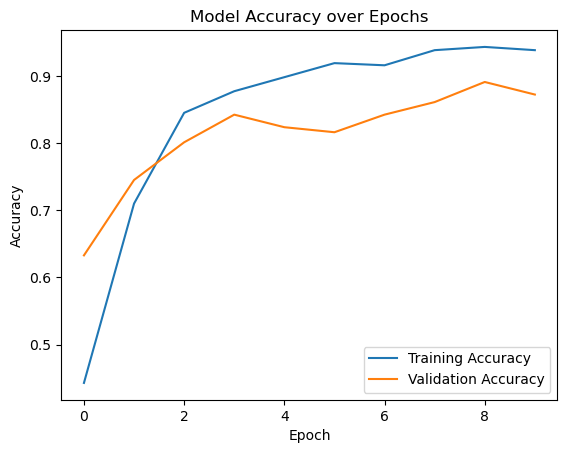

In [95]:
# Visualize model training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy over Epochs')
plt.show()

In [146]:
# from mrcnn import model as modellib
# from mrcnn.config import Config

# from mrcnn.model import MaskRCNN

# class CustomConfig(Config):
#     # Give the configuration a recognizable name
#     NAME = "custom_config"

#     # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1
#     STEPS_PER_EPOCH = 100
#     VALIDATION_STEPS = 50
#     NUM_CLASSES = 1 + 1  # 1 (objet + background)
# # Create the configuration
# config = CustomConfig()

# # Chargez votre ensemble de données d'entraînement et de validation
# train_dataset2 = train_batches
# val_dataset2 = validation_batches

# # Créez le modèle Mask R-CNN en mode entraînement
# model_maskrcnn = MaskRCNN(mode="training", config=config, model_dir='./logs')

# # Entraînez votre modèle avec vos données
# model_maskrcnn.train(train_dataset, val_dataset, learning_rate=0.001, epochs=10, layers='all')

# # model = modellib.MaskRCNN(mode="training", config=config, model_dir='./logs')


# # # Entraînez votre modèle avec vos données
# # model.train(train_dataset, learning_rate=0.001, epochs=10, layers='all')


# # # model.fit(train_batches, validation_data=validation_batches, epochs=3)

# # # Une fois l'entraînement terminé, vous pouvez utiliser le modèle pour la détection ou la segmentation d'objets
# # # Exemple de détection d'objets sur une image
# # image = Image.open("C:/Users/user/Desktop/Projet deep learning/objets_extraits/4_239.jpg")
# # results = model.detect([image], verbose=1)


## Quelques essaies de predictions 

In [93]:

# # Charger l'image à prédire
# new_image = Image.open("C:/Users/user/Desktop/Projet deep learning/objets_extraits/4_239.jpg")
# new_image = new_image.resize((224, 224))  # Redimensionner l'image si nécessaire
# new_image = np.array(new_image) / 255.0  # Normaliser les valeurs de pixel (mise à l'échelle entre 0 et 1)
# new_image = np.expand_dims(new_image, axis=0)  # Ajouter une dimension pour créer un lot (batch)

# # Faire la prédiction
# predictions = model.predict(new_image)

# # Convertir les scores de prédiction en classes
# predicted_class = np.argmax(predictions, axis=1)

# # Afficher la classe prédite
# print("Classe prédite :", predicted_class)

In [149]:
# from tensorflow.keras.preprocessing import image
# image_files = os.listdir(extracted_objects_folder)

# # Boucler sur chaque fichier d'image
# for image_file in image_files:
#     # Construire le chemin complet de l'image
#     image_path = os.path.join(extracted_objects_folder, image_file)
    
#     # Charger l'image avec les dimensions spécifiées (par exemple, 224x224)
#     img = image.load_img(image_path, target_size=(224, 224))
#     # Prétraiter l'image pour l'adapter au modèle (par exemple, normalisation)
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = img / 255.0  # Normalisation
    
#     # Prédire la classe de l'image
#     predictions = model.predict(img)
#     # Convertir les prédictions en classes prédites
#     predicted_class = np.argmax(predictions, axis=1)
    
#     # Afficher le nom de l'image et la classe prédite
#     print(f"Image : {image_file}, Classe prédite : {predicted_class}")

## Pre-trained Model : RES_NET 50  (voir captures)

In [ ]:
#REMARQUE : A ne pas excecuter (prend beaucoup de temps et de memoire !!!)

# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Input, Conv2DTranspose, Conv2D, Dense
# from tensorflow.keras.models import Model

# # Charger le modèle pré-entraîné (exemple avec ResNet50)
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# # Freeze the layers of the base model
# for layer in base_model.layers:
#     layer.trainable = False

# x = Flatten()(base_model.output)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(11, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)


# # Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
# model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# model.summary()
# # epochs=15

# # history = model.fit(
# #   train_batches,
# # #   validation_data=validation_batches,
# #   epochs=epochs
# # )




In [ ]:
history = model.fit(
    train_batches,
#   validation_data=validation_batches,
    epochs=10
)

In [ ]:
# A termienr : courbe de comparaison des optimaizers Adam .... comme montionné dans l'article !!

### Conclusion : VVG est meilleur que RESNET 50 meme dans la prediction il est trés précis comme model pré-entrainé !!

# YOLO V5

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirement ['gitpython>=3.1.30'] not found, attempting AutoUpdate...
  Obtaining dependency information for gitpython>=3.1.30 from https://files.pythonhosted.org/packages/e9/bd/cc3a402a6439c15c3d4294333e13042b915bbeab54edc457c723931fed3f/GitPython-3.1.43-py3-none-any.whl.metadata
  Obtaining dependency information for gitdb<5,>=4.0.1 from https://files.pythonhosted.org/packages/fd/5b/8f0c4a5bb9fd491c277c21eff7ccae71b47d43c4446c9d0c6cff2fe8c2c4/gitdb-4.0.11-py3-none-any.whl.metadata
   -------------------------------------- 207.3/207.3 kB 485.5 kB/s eta 0:00:00
   ---------------------------------------- 62.7/62.7 kB 419.8 kB/s eta 0:00:00

requirements: AutoUpdate success  7.7s, installed 1 package: ['gitpython>=3.1.30']
requirements:  Restart runtime or rerun command for updates to take effect



YOLOv5  2024-4-16 Python-3.11.4 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


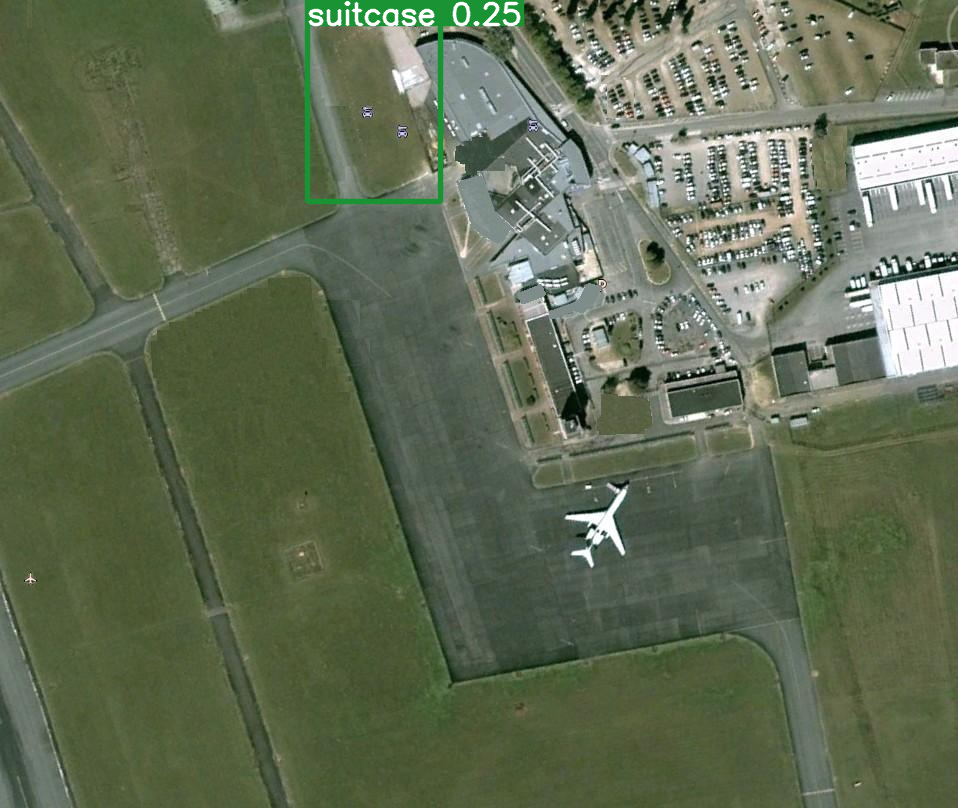

tensor([[3.07562e+02, 0.00000e+00, 4.40870e+02, 2.01826e+02, 2.54482e-01, 2.80000e+01]])


In [152]:
import torch
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from torchvision.transforms import functional as F

# Charger le modèle YOLOv5 pré-entraîné
modelYolo = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Chemin de l'image que vous souhaitez analyser
image_path = 'C:/Users/user/Desktop/Projet deep learning/positive image set/001.jpg'

# Charger l'image à l'aide de PIL
image = Image.open(image_path)

# Effectuer la détection d'objets
results = modelYolo(image)

# Afficher les résultats de la détection
results.show()

# Afficher les informations sur les détections (classes, boîtes englobantes, scores)
print(results.xyxy[0])  # xyxy format: [xmin, ymin, xmax, ymax, conf, cls]

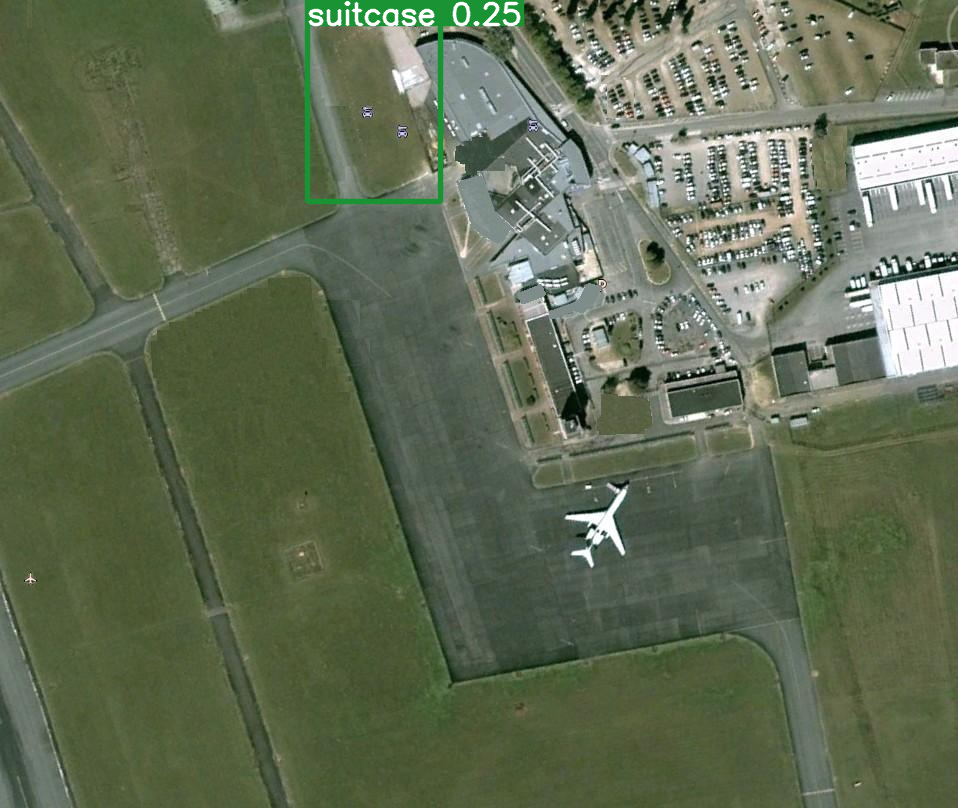

tensor([[3.07562e+02, 0.00000e+00, 4.40870e+02, 2.01826e+02, 2.54482e-01, 2.80000e+01]])
Classe : 28.0, Score de confiance : 0.25448158383369446


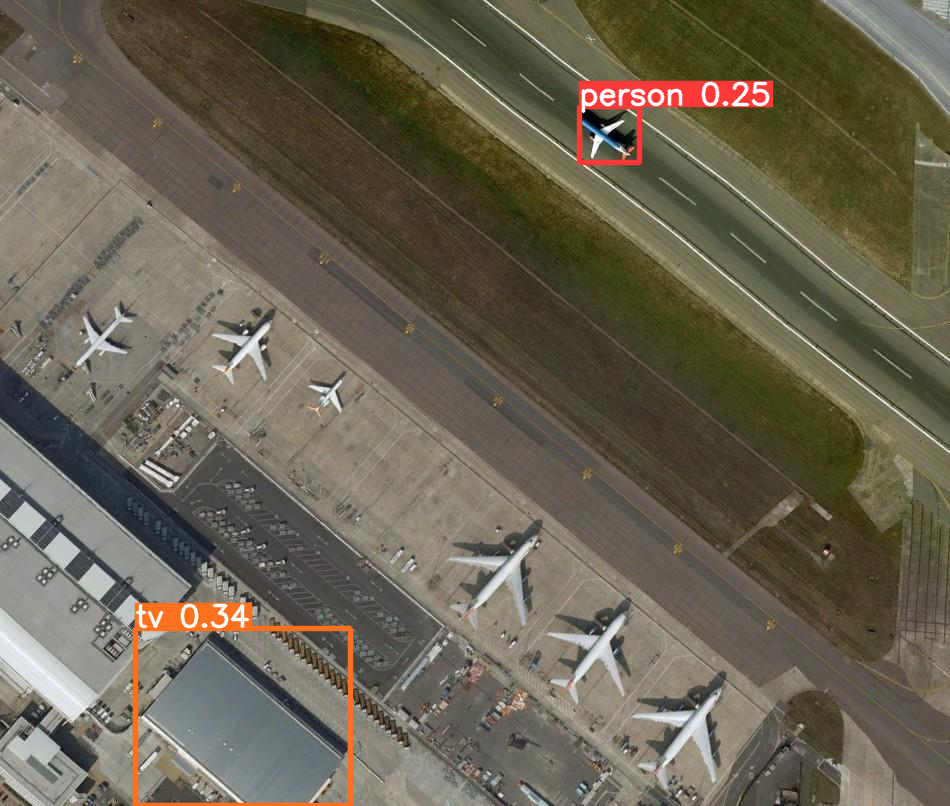

tensor([[1.35012e+02, 6.28068e+02, 3.50788e+02, 8.05755e+02, 3.39778e-01, 6.20000e+01],
        [5.79625e+02, 1.06443e+02, 6.39347e+02, 1.62174e+02, 2.54110e-01, 0.00000e+00]])
Classe : 62.0, Score de confiance : 0.3397776484489441
Classe : 0.0, Score de confiance : 0.2541104853153229


NameError: name 'correct_predictions' is not defined

In [156]:
for image_p in image_paths:
    # Charger l'image à l'aide de PIL
    total_predictions=0
    total_predictions=0
    image = Image.open(image_p)
    # Effectuer la détection d'objets
    results = modelYolo(image)

    # Afficher les résultats de la détection
    results.show()
    
    # Afficher les informations sur les détections (classes, boîtes englobantes, scores)
    print(results.xyxy[0])  # xyxy format: [xmin, ymin, xmax, ymax, conf, cls]
    detections = results.xyxy[0]
     # Parcourir chaque détection
    for detection in detections:
        xmin, ymin, xmax, ymax, conf, cls = detection.tolist()
        
        # Afficher le score de confiance
        print(f"Classe : {cls}, Score de confiance : {conf}")
        
        # Votre logique pour calculer l'accuracy
        total_predictions += 1
        if cls == 0:  # Exemple : si la classe est 0 (classe spécifique), considérez-la comme une prédiction correcte
            correct_predictions += 1


# Calcul de l'accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy : {accuracy}")


# Phase d'analyse de performance des modéles

## Affichage de nombre d'objets par leurs types 

In [ ]:
##Dans le cas general
from collections import Counter

# Compter le nombre de chaque valeur
compteur = Counter(labelsFin)

# Afficher le résultat
print(compteur)

In [ ]:
class_names = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}


In [ ]:
# Résultat de Counter
counter_result = {4: 176, 7: 163, 5: 108, 1: 90, 10: 86, 6: 86, 9: 67, 2: 57, 3: 28, 8: 27}

# Transformer en dictionnaire
result_dict = {class_names[key]: value for key, value in counter_result.items()}

print(result_dict)

In [ ]:
##Train , test 

# Compter le nombre de chaque valeur
compteurTrain = Counter(y_train)
# Compter le nombre de chaque valeur
compteurTest = Counter(y_test)

# Afficher le résultata
print(compteurTrain)
print(compteurTest)

In [ ]:
counter_result_train={4: 118, 7: 117, 1: 71, 5: 69, 6: 61, 10: 57, 9: 49, 2: 42, 3: 20, 8: 17}
counter_result_test={4: 16, 7: 16, 5: 13, 10: 12, 2: 8, 6: 7, 1: 5, 8: 4, 3: 4, 9: 4}
# Transformer en dictionnaire
result_dict_train = {class_names[key]: value for key, value in counter_result_train.items()}
result_dict_test = {class_names[key]: value for key, value in counter_result_test.items()}

print(result_dict_train)
print(result_dict_test)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# Extraire les types d'objets et les nombres d'occurrences pour l'entraînement et le test
objects = list(result_dict_train.keys())
train_counts = list(result_dict_train.values())
test_counts = list(result_dict_test.values())

df_train = pd.DataFrame(result_dict_train.items(), columns=['Object', 'Train Count'])
df_test = pd.DataFrame(result_dict_test.items(), columns=['Object', 'Test Count'])

# Fusionner les deux DataFrames pour faciliter la visualisation
df_combined = pd.merge(df_train, df_test, on='Object')

# Définir le style de Seaborn
sns.set(style="whitegrid")

# Créer le graphique
plt.figure(figsize=(10, 6))
sns.barplot(x='Train Count', y='Object', data=df_combined, color='skyblue', label='Train')
sns.barplot(x='Test Count', y='Object', data=df_combined, color='salmon', label='Test')

# Ajouter des titresa et une légende
plt.xlabel('Nombre d\'occurrences')
plt.title('Nombre d\'objets détectés par type dans l\'ensemble d\'entraînement et de test')
plt.legend()

# Afficher le graphique
plt.show()

## Comparaisons des optimizers selon l'article (presion + recall)

# Fin De l'essaie 2 

# Essaie 3 (echoué)

## Tester ces trois essais sur ce model

In [ ]:
# def preprocess_image(image, label):
#     # Convertir le type de données de l'image en flottant si ce n'est pas déjà le cas
#     if image.dtype != tf.float32:
#         image = tf.cast(image, tf.string)
    
#     # Normaliser les valeurs de pixel à [0, 1]
#     image = image / 255.0
    
#     # Redimensionner l'image à la taille souhaitée (224x224) en maintenant les proportions
#     if len(image.shape) == 3:
#         # Si l'image a 3 dimensions (sans lot), redimensionner directement
#         image = tf.image.resize(image, (224, 224))
#     elif len(image.shape) == 4:
#         # Si l'image a 4 dimensions (avec lot), redimensionner chaque image individuellement
#         image = tf.image.resize(image[:, :, :, :], (224, 224))
#     else:
#         raise ValueError('Invalid image shape. Must have either 3 or 4 dimensions.')

#     return image, label


In [ ]:
# # Appliquer la fonction de prétraitement aux données d'entraînement et de validation
# train_dataset = train_dataset.map(preprocess_image)
# val_dataset = val_dataset.map(preprocess_image)

In [ ]:
# Création d'un modèle simple (vous pouvez le remplacer par n'importe quel modèle que vous souhaitez entraîner)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')  # 10 classes dans votre cas
])


# Compiler le modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,run_eagerly=True,
              metrics=['accuracy']
             )
model.summary()

# image_path = "C:/Users/user/Desktop/Projet deep learning/positive image set/202.jpg"


In [ ]:
# Fonction pour extraire la classe à partir de l'étiquette
def extract_class(label):
    # Diviser l'étiquette en parties en utilisant ',' et ' ' comme délimiteurs
    parts = label.split(',')
    # La classe est généralement la dernière partie après le dernier espace
    class_part = parts[-1].split(' ')[-1]
    # Convertir la classe en entier et la renvoyer
    return int(class_part)

# Convertir les étiquettes en entiers en extrayant la classe
# train_labels_int = [extract_class(label) for label in train_labels]
# val_labels_int = [extract_class(label) for label in val_labels]

In [ ]:
# # Entraîner votre modèle avec les données batchées


# history1 = model.fit(image_dataset, validation_data=val_dataset, epochs=5)

# history3 = model.fit(train_dataset_resized.batch(32), validation_data=val_dataset_resized, epochs=5)

In [ ]:
# Define the function that will be decorated with tf.function
def train_model( train_dataset, val_dataset, epochs):
    # Compile the model
    # Train the model
    model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='softmax')  # 10 classes dans votre cas
])


# Compiler le modèle
    model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,run_eagerly=True,
              metrics=['accuracy']
             )
    history = model.fit(train_dataset.batch(64), validation_data=val_dataset, epochs=epochs)

    return history


# Train the model
history2 = train_model( train_dataset_resized, val_dataset_resized, epochs=5)

In [ ]:
# # Entraîner le modèle avec les générateurs
# history = model.fit(
#     #ki T7ot el batch size twelli=(None, 224, 224, 3) ki tna7ih iwelli  found shape=(224, 224, 3)
#     train_dataset_resized,
#     epochs=5,
#   validation_data=val_dataset_resized
# )

In [ ]:
# # Fonction pour charger et redimensionner une image
# def load_and_resize_image(image_path, label):
#     # Charger l'image depuis le chemin spécifié
#     image = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(image, channels=3)  # Décodez l'image en RGB

#     # Redimensionner l'image à la taille cible
#     image = tf.image.resize(image, target_size)

#     return image, label

In [ ]:
# load_and_resize_image(image_path, label)

In [ ]:
resized_images=[]
for jj in range(len(image_paths)):
    resized_images.append(load_and_resize_image(image_paths[jj], processed_labels_strings_np))
    
    
    


In [ ]:
len(processed_labels_strings_np)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Charger et redimensionner les images de manière cohérente
resized_images_Z = []
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_dir, filename)
        img = load_img(image_path, target_size=(224, 224))  # Remplacez desired_height et desired_width par les dimensions souhaitées
        img_array = img_to_array(img)
        resized_images_Z.append(img_array)

# Convertir les images en tableau NumPy
X = np.array(resized_images_Z)


In [ ]:
processed_labels_strings_np

In [ ]:
label_to_int

In [ ]:
# # Convertir les labels en entiers avant de les convertir en tenseur TensorFlow
# processed_labels_int = [str(label) for label in processed_labels_strings_np]

# # Convertir la liste en un tableau NumPy avec le bon type de données
# processed_labels_np = np.array(processed_labels_int)  # Utilisation de np.int128

# # Convertir le tableau NumPy en tenseur TensorFlow

#############REMARQUE KI AAAMLLNA EL CODA HEDHA MCHA AMMA ACCRACY 5AYAB !!!##############
# Assuming your original labels are in the `labels_strings` list
# label_to_id = {}
# ids = []

# # Create a dictionary that maps labels to unique integers
# for  label in processed_labels_strings_np:
#     label_to_id[label] = i

# # Convert string labels to integer labels
# for label in processed_labels_strings_np:
#     ids.append(label_to_id[label])

# # Convert the list to a numpy array
# training_labels = np.array(ids)
#########################################################################################

# training_padded = np.array(resized_images)
# training_labels = np.array(processed_labels_strings_np)

# labels_tensor = tf.ragged.constant(processed_labels_strings_np,dtype=tf.string)  

# X=np.array(resized_images)

# Convertir les images en tenseur TensorFlow


labels_array=np.array(labels_integers)

# Entraîner le modèle avec les générateurs
history = model.fit(X, labels_array, epochs=4,validation_split=0.3)




# # Diviser les données en ensembles d'entraînement et de validation
# train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
#     image_paths, processed_labels_strings_np, test_size=0.2, random_state=42)            

In [ ]:
# # Entraîner le modèle avec les générateurs
# history = model.fit(
#     dataset.batch(32),
#     epochs=10,
# #    validation_data=val_dataset
# )

In [ ]:
# history = model.fit(x=np.array(train_image_paths), y=np.array(train_labels), epochs=3, validation_data=(np.array(val_image_paths), np.array(val_labels)), validation_freq=5)


In [ ]:
IMG_SIZE = 224


# Créer une liste pour stocker les images redimensionnées
resized_images = []

# Parcourir les chemins d'images et charger les images
for image_path in train_image_paths:
    # Charger l'image depuis le chemin
    image = cv2.imread(image_path)
    # Redimensionner l'image à la taille 224x224
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    # Ajouter l'image redimensionnée à la liste
    resized_images.append(image)

    
# num_classes = 11
# y_one_hot = np.zeros((len(y), num_classes))

# # Remplir y_one_hot avec des valeurs one-hot
# for i in range(len(y)):
#     y_one_hot[i, y[i]] = 1


# y_one_hot = np.zeros((len(y), 11))

# # Remplir y_one_hot avec des valeurs one-hot
# for i in range(len(y_one_hot[1])+1):
#     y_one_hot[i, y[i]] = 1


# X = np.array(resized_images)



# # Convertir les données d'entraînement en tenseurs NumPy
# X_train = np.array(resized_images)
# y_train = np.array(train_labels)


# batch_size = 32
# x_train = X_train.reshape((batch_size, 224, 224, 3))
# x_train = x_train.reshape((batch_size, -1))



history = model.fit(train_dataset , epochs=40, validation_data=val_dataset)




In [ ]:
# # Visualiser l'overfitting
# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
# plt.show()

# Test de Predictions

In [ ]:

# Charger l'image à prédire
new_image = Image.open("C:/Users/user/Desktop/Projet deep learning/positive image set/462.jpg")
new_image = new_image.resize((224, 224))  # Redimensionner l'image si nécessaire
new_image = np.array(new_image) / 255.0  # Normaliser les valeurs de pixel (mise à l'échelle entre 0 et 1)
new_image = np.expand_dims(new_image, axis=0)  # Ajouter une dimension pour créer un lot (batch)

# Faire la prédiction
predictions = model.predict(new_image)

# Convertir les scores de prédiction en classes
predicted_class = np.argmax(predictions, axis=1)

# Afficher la classe prédite
print("Classe prédite :", predicted_class)

In [ ]:
# Obtenir un batch d'images et de labels de l'ensemble de validation
for images, labels in train_dataset.take(10):
    # Prédire les labels des images
    predictions = model.predict(images)
    # Convertir les prédictions en classes prédites
    predicted_classes = np.argmax(predictions, axis=1)
    
# processed_labels_tuples
# labels_tensor
    # Afficher chaque image avec sa valeur réelle et sa valeur prédite
    for i in range(len(images)):
        # Afficher l'image
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Valeur réelle: {processed_labels_tuples[i]}  |  Valeur prédite: {predicted_classes[i]}")
        plt.axis("off")
        plt.show()

In [ ]:
f=[]
for labels in data.take(10):
    f.append(labels)
    

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # Fonction pour afficher une image avec les annotations
# def afficher_image(image, valeur_reelle, valeur_predite, box_predite):
#     # Créer une figure et un axe
#     fig, ax = plt.subplots()

#     # Afficher l'image
#     ax.imshow(image)

#     # Colorer la valeur réelle en rouge
#     if valeur_reelle == "airplane":
#         couleur_reelle = "red"
#     else:
#         couleur_reelle = "black"
#     ax.text(10, 10, f"Valeur réelle: {valeur_reelle}", color=couleur_reelle)

#     # Colorer la valeur prédite en bleu
#     if valeur_predite == "airplane":
#         couleur_predite = "blue"
#     else:
#         couleur_predite = "black"
#     ax.text(10, 30, f"Valeur prédite: {valeur_predite}", color=couleur_predite)

#     # Dessiner le box prédite en rouge
#     x, y, w, h = box_predite
#     rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)

#     # Afficher l'image avec les annotations
#     plt.show()

# # Exemple d'utilisation
# image = plt.imread("positive image set/001.jpg")
# valeur_reelle = "airplane"
# valeur_predite = "ship"
# box_predite = (100, 100, 50, 50)  # Exemple de box prédite : (x, y, largeur, hauteur)

# afficher_image(image, valeur_reelle, valeur_predite, box_predite)

In [ ]:
# Créer un dictionnaire pour mapper les numéros de classe aux noms de classes
class_names = {1: "airplane", 2: "ship", 3: "storage tank", 4: "baseball diamond", 5: "tennis court",
               6: "basketball court", 7: "ground track field", 8: "harbor", 9: "bridge", 10: "vehicle"}

# Obtenir un batch d'images et de labels de l'ensemble de validation
for images, labels in image_dataset.take(1):
    # Prédire les labels des images
    predictions = model.predict(images)
    # Convertir les prédictions en classes prédites
    predicted_classes = np.argmax(predictions, axis=1)

    # Afficher chaque image avec sa valeur réelle et sa valeur prédite
    for i in range(len(images)):
        # Afficher l'image
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Obtenir le nom de la classe réelle et prédite
        real_class_name = class_names[int(labels[i])]
        predicted_class_name = class_names[int(predicted_classes[i])]
        
        # Définir la couleur du texte en fonction de la classe réelle et prédite
        if real_class_name == predicted_class_name:
            text_color = 'black'  # Si la prédiction est correcte, le texte sera en noir
        else:
            text_color = 'red'    # Si la prédiction est incorrecte, le texte sera en rouge
            
        # Afficher le titre avec la valeur réelle et prédite
        plt.title(f"Valeur réelle: {real_class_name}  |  Valeur prédite: {predicted_class_name}", color=text_color)
        plt.axis("off")
        plt.show()


In [ ]:

# # Parcourir chaque image et son fichier de vérité terrain
# for image_id in range(1,20):
#     # Charger l'image
#     image_path = image_folder + f"{image_id:03d}.jpg"
#     image = cv2.imread(image_path)
    
#     # Charger les coordonnées des boîtes englobantes à partir du fichier de vérité terrain
#     ground_truth_path = ground_truth_folder + f"{image_id:03d}.txt"
#     with open(ground_truth_path, 'r') as file:
#         lines = file.readlines()
#         for line in lines:
#             coordinates = extract_coordinates(line)
#             parts = line.strip().split(',')
#             boxes = []
#             if coordinates:
#                 x1, y1, x2, y2 = coordinates
#                 label = int(parts[4])
#                 class_name = class_names[label]
#                 boxes.append((x1, y1, x2, y2, int(label)))
                
#                 # Dessiner un rectangle sur l'image
#                 cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
#             # Afficher le label à côté de la boîte englobante
#                 cv2.putText(image, str(class_name), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


In [ ]:
positive_image_dir2 = "C:/Users/user/Desktop/Projet deep learning/positive image set/pppp"
images = []
labels = []
for filename in os.listdir(positive_image_dir2):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image = cv2.imread(os.path.join(image_dir, filename))
        
        images.append(image)
        
        # Prétraitement de l'image si nécessaire (redimensionnement, normalisation, etc.)
        label = filename.split("-")[0]  # Exemple : "1-airplane.jpg" -> étiquette "1"
        label = label.split('.')[0]  # Supprimer l'extension pour obtenir "1"
        labels.append(int(label))  # Convertir l'étiquette en entier
        # Ajouter l'étiquette en fonction du nom du fichier ou de son répertoire parent

# Convertir les listes en tableaux numpy
images = np.array(images)
labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [ ]:
# Vérifier les dimensions des ensembles d'entraînement et de test
print("Dimensions de x_train:", x_train.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de x_test:", x_test.shape)
print("Dimensions de y_test:", y_test.shape)

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K 
# set some more parameters
img_rows, img_cols = 224, 224
#image_size=(224, 224),
filters = 32
pool_size = 2
kernel_size = 3
# set some parameters
batch_size = 128
num_classes = 5
epochs = 5
if K.image_data_format() == 'channels_first': # 'channels_first' of 64*64 RGB image (3,64,64),  commonly used with frameworks like Theano.
    input_shape = (1, img_rows, img_cols)
else:                                        # 'channels_Last' of 64*64 RGB image (64,64,3),  commonly used with frameworks like Tensorflow.
    input_shape = (img_rows, img_cols, 1)

feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',   # valid: no padding, same: feature map size=input img size
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

In [ ]:
# Define the "classification" layers.  These are the later layers that predict the specific classes from the features
# learned by the feature layers.  This is the part of the model that needs to be re-trained for a new problem

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]
# We create our model by combining the two sets of layers as follows
model = Sequential(feature_layers + classification_layers)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))


In [ ]:
ground_truth_folder = "ground truth/"
class_names = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

Images_train=[]
y_train=[]
# Parcourir chaque image et son fichier de vérité terrain
for image_id in range(1, 651):
    # Charger l'image
    image_path = image_folder + f"{image_id:03d}.jpg"
    image = cv2.imread(image_path)
    
    Images_train.append(image)
    
    # Charger les coordonnées des boîtes englobantes à partir du fichier de vérité terrain
    ground_truth_path = ground_truth_folder + f"{image_id:03d}.txt"
    with open(ground_truth_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            coordinates = extract_coordinates(line)
            parts = line.strip().split(',')
            if coordinates:
                x1, y1, x2, y2 = coordinates
                label = int(parts[4])
                class_name = class_names[label]
                y_train.append(label)
                # Dessiner un rectangle sur l'image
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Afficher le label à côté de la boîte englobante
                cv2.putText(image, str(class_name), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

#     # Afficher l'image avec les boîtes englobantes
#     plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#     plt.title(f"Image {image_id}")
#     plt.axis('off')
#     plt.show()

In [ ]:
# Utiliser len() pour obtenir la longueur de la liste
longueur_liste = len(y_train)
longueur_liste2 = len(Images_train)


In [ ]:
longueur_liste,longueur_liste2

In [ ]:
DATADIR = "positive image set"
TESTDIR = "test"
LABELS = ["airplane","ship","storage tank", "baseball diamond", "tennis court",
               "basketball court", "ground track field", "harbor", "bridge", "vehicle"]

X_TRAIN = []
Y_TRAIN = []

IMG_SIZE = 100
for category in LABELS:
    path = os.path.join(DATADIR, category)
    class_num = LABELS.index(category)
    for img in image_paths:
        try:
            img_array = cv.imread(os.path.join(path, img))
            new_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
            X_TRAIN.append(new_array)
            Y_TRAIN.append(class_num)
        except Exception as e:
            pass
            
X_TRAIN = np.array(X_TRAIN).reshape(-1, IMG_SIZE, IMG_SIZE,3)
Y_TRAIN = np.array(Y_TRAIN)

X_TRAIN = X_TRAIN/255

In [ ]:
# model = Sequential()

# model.add(Conv2D(32, (5,5), input_shape=(224,224,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(4,4)))

# model.add(Conv2D(64, (5,5)))  # Augmentation du nombre de filtres
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(3,3)))

# model.add(Conv2D(128, (5,5)))  # Ajout d'une couche Conv2D avec plus de filtres
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Flatten())
# model.add(Dense(64))


# model.add(Activation("relu"))
# model.add(Dropout(0.3))  # Ajout d'une couche Dropout pour la régularisation

# model.add(Flatten())
# model.add(Dense(1))
# model.add(Activation("softmax"))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(train_dataset_resized.batch(64), epochs=5,validation_data=val_dataset_resized.batch(64))

# Pre trained Model 

In [ ]:
# from tensorflow.keras import layers
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras import layers, Model
# input_shape = (224,224,3)
# model_1 = VGG16(weights='imagenet',include_top=False,input_shape=input_shape)
# Last_layer=model_1.layers[-1].output
# print(Last_layer)
# print(type(Last_layer))
# Model_Vgg=layers.Flatten()(Last_layer)
# Model_Vgg = layers.Dropout(0.5)(Model_Vgg)
# Model_Vgg = layers.Dense(units=3, activation='softmax') (Model_Vgg)

# modelVggM = Model(inputs =model_1.input,outputs = Model_Vgg )
# modelVggM.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.SGD(learning_rate=0.005708),metrics=['accuracy'])

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Flatten
# from tensorflow.keras.optimizers import Adam

# # Charger le modèle VGG16 pré-entraîné sans les couches de classification
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Geler les couches du modèle pré-entraîné
# for layer in base_model.layers:
#     layer.trainable = False

# # Créer le modèle complet en ajoutant des couches supplémentaires
# model = Sequential()
# model.add(base_model)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))  # Utiliser 'sigmoid' pour une classification binaire

# # Compiler le modèle
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Entraîner le modèle
# history = model.fit(train_dataset_resized.batch(64), epochs=20, validation_data=val_dataset_resized.batch(64))

# # Évaluer le modèle
# test_loss, test_acc = model.evaluate(test_dataset_resized.batch(64))
# print("Accuracy sur l'ensemble de test:", test_acc)


In [ ]:
# input_shape = (224, 224, 3)
# base_model = modelVggM
# last_layer = base_model.layers[-1].output

# flatten_layer = layers.Flatten()(last_layer)
# dropout_layer = layers.Dropout(0.5)(flatten_layer)
# dense_layer = layers.Dense(units=1, activation='softmax')(dropout_layer)

# model_final = Model(inputs=base_model.input, outputs=dense_layer)

# model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Assurez-vous d'avoir vos données d'entraînement (X_train, y_train) et de validation (X_val, y_val) prêtes
# model_final.fit(train_dataset_resized.batch(64), epochs=10, validation_data=val_dataset_resized.batch(64))


# Fin de l'essaie 3